# Nina Stawski's (group 90) final project report

Illinois ID: ninas2


[GitHub repo link](https://github.com/nstawski/dlh-final-project)

# Introduction

## Background of the problem

### Type of problem
  
  This is a data preparation and processing problem. The authors of the article are testing a common belief that adding more data improves the resulting model performance. Their main hypothesis, which they subsequently prove, is that incorporating more data does not necessary improve the model performance. It can introduce spurious correlations, and hurt the resulting model performance rather than helping it.

### What is the importance/meaning of solving the problem
  
  The paper is challenging a common belief, meaning a lot of researchers are likely trying to incorporate as much data as they can expecting it would improve the performance of their models. The outcome of this research would provide guidance on the possible pitfalls and the cases where you wouldn't want to add external data - so it could set a new standard of processing and incorporating data for everyone in the field.

### The difficulty of the problem

  The problem is non-obvious and the paper is challenging the common belief held in the industry. The authors are putting a lot of state-of-the-art approaches to the test, and attempt to quantify the results as well as provide new standards and explanations. This is extremely hard to do so I believe the problem is difficult.

### The state of the art methods and effectiveness

  The "industry standard" way of improving model performance is adding more data from additional datasets, which the authors of this article prove to not be effective, and even being harmful in many cases.

  One of the main issues causing the model performance decrease when adding more data from other sources is spurious correlations, which in case of x-rays could be coming even from the scanner artifacts, or other hospital-specific data. One of the state-of-the-art ways to mitigate this is balancing a dataset to reduce the influence of hospital-specific factors. While balancing definitely improved the situation, the resulting model performance was still in many cases worse than with a single-hospital dataset.


## Paper explanation
### What did the paper propose
The paper used four most-used chest x-ray datasets - MIMIC-CXR-JPG, CheXpert, PadChest, ChestXray8 - to disprove a popular belief that adding more data always would improve the performance of your model. They postulate that, for the specific x-ray data, even the scanners themselves, the way hospitals produce data, or send specific patients to specific places to do their scan, can introduce spurious correlations which, in many cases, significantly affect the worst group performance.

### What is the innovations of the method
Existing research (for example, John R Zech, Marcus A Badgeley, Manway Liu, Anthony B Costa, Joseph J Titano, and Eric Karl Oermann. Variable generalization performance of a deep learning model to detect pneumonia in chest radiographs: a cross-sectional study. PLoS medicine, 15(11): e1002683, 2018.) proves that adding a second dataset improves the average per-group accuracy. In contrast, the paper I am reproducing focuses on the worst per-group accuracy.

### How well the proposed method work (in its own metrics)
According to the article authors, their method works really well and proves that in nearly 50% of cases adding a second dataset, and even balancing it to reduce spurious correllations doesn't get the model to perform better than without that additional dataset. The models pick up on hospital-specific features even if those features weren't explicitly defined in the original data. They postulate that every CNN model, regardless of training disease or datasets, learns embeddings that can distinguish any of the hospital sources with near-perfect accuracy, even if the embeddings were trained via one or two hospitals’ data.

### What is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).

The article cautions against blindly adding more datasets, and provides a number of approaches you can take if you still decide to do so. The conclusion is adding more data shouldn't be done blindly. The authors of the article definitely discourage the researchers from the most common approach of throwing data at the problem to improve model performance.


# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.

![Paper overview](https://raw.githubusercontent.com/basedrhys/ood-generalization/5d8ff09eba4c0b4b20b5ae2814fe865bed1dfb0e/img/high_level_overview.png)

## Hypothesis 1

In 43% of training dataset/disease tasks, adding data from an external source hurts worst-group performance.


## Hypothesis 2

Balancing the dataset to reduce spurious correlations is often beneficial, but in the scenarios where adding an additional data source hurts generalization performance, it does not always improve generalization; in some cases, training on a balanced dataset achieves lower worst-group accuracy than training on datasets from one or two hospitals.


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [5]:
!pip install importlib
!pip install torch
!pip install torchvision
!pip install pandas
!pip install matplotlib
!pip install imblearn

     -------------------------------------- 162.8/162.8 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 7.7/7.7 MB 17.5 MB/s eta 0:00:00
   --------------------------------------- 187.5/187.5 kB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 2.2/2.2 MB 23.2 MB/s eta 0:00:00
   ---------------------------------------- 56.1/56.1 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 103.2/103.2 kB ? eta 0:00:00


In [1]:
# import  packages you need
import numpy as np
import pandas as pd
from pathlib import Path
import os
from os.path import exists
import sys
import matplotlib.pyplot as plt
from PIL import Image
import json
import random
from IPython.display import display
from datetime import datetime
from sklearn.metrics import f1_score
# from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

import Data_Constants as Constants

#making sure all referenced files are reloaded
import importlib
importlib.reload(Constants)


<module 'Data_Constants' from 'C:\\Users\\Stan\\Documents\\GitHub\\dlh-final-project\\Data_Constants.py'>

In [2]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
# torch.set_default_device('cuda')

torch.set_default_tensor_type('torch.cuda.FloatTensor')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

print(torch.cuda.is_available())

True


#  Data
The study is using four datasets: MIMIC-CXR-JPG, CheXpert, PadChest, ChestXray8

The datasets are being filtered to include only frontal (PA/AP) images. Instances are labeled with one or more pathologies. Each dataset has a different set of diseases but they are preprocessed using code derived from ClinicalDG2 (Zhang et al., 2021) to extract the eight common labels and homogenize the datasets. Additionally, authors of the article created the Any label which indicates a positive label for any of the seven common disease labels, resulting in nine different binary labels. All experiments use the labels in a binary manner; a pathology is chosen as the target label, with an instance labeled 1 if the pathology of interest is present and 0 otherwise. 

The autors apply an 80%/10%/10% subject-wise train/val/test split, with the same split used across seeds.

### MIMIC-CXR

1. [Obtain access](https://mimic-cxr.mit.edu/about/access/) to the MIMIC-CXR-JPG Database Database on PhysioNet and download the [dataset](https://physionet.org/content/mimic-cxr-jpg/2.0.0/). The best option is downloading from the GCP bucket:

```sh
gcloud auth login
mkdir MIMIC-CXR-JPG
gsutil -m rsync -d -r gs://mimic-cxr-jpg-2.0.0.physionet.org MIMIC-CXR-JPG
```

2. In order to obtain gender information for each patient, you will need to obtain access to [MIMIC-IV](https://physionet.org/content/mimiciv/0.4/). Download `core/patients.csv.gz` and place the file in the `MIMIC-CXR-JPG` directory.

### CheXpert
1. Sign up with your email address [here](https://stanfordmlgroup.github.io/competitions/chexpert/).

2. Download either the original or the downsampled dataset (we recommend the downsampled version - `CheXpert-v1.0-small.zip`) and extract it.

### ChestX-ray8

1. Download the `images` folder and `Data_Entry_2017_v2020.csv` from the [NIH website](https://nihcc.app.box.com/v/ChestXray-NIHCC).

2. Unzip all of the files in the `images` folder.

### PadChest

1. The paper uses a resized version of PadChest, which can be downloaded [here](https://academictorrents.com/details/96ebb4f92b85929eadfb16761f310a6d04105797).

2. Unzip `images-224.tar`.

  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.
  
## Data Processing
The original pre-processing for the article was done using the scripts outside of the Jupyter Notebook. Some of them didnt' work for me, and the installation process didn't succeed despite multiple attempts either. Instead, I have adapted some of the original scripts to run in the notebook (with some modifications so they actually work with my data), using the external "Constants.py" file that points to the location of the datasets.
1. In `./Data_Constants.py`, update `image_paths` to point to each of the four directories that you downloaded.

2. Run the next two cells to pre-process the data

## Validating
I am using the validation and pre-processing code provided by the authors of the article, with some modifications to make it run as expected.

In [3]:
#making sure constants are up to date if they were changed
importlib.reload(Constants)

def validate_mimic():
    img_dir = Path(Constants.image_paths['MIMIC'])
    meta_dir = Path(Constants.meta_paths['MIMIC'])
    
    print('meta_dir', meta_dir, os.getcwd())
    print('meta_dir', meta_dir/'mimic-cxr-2.0.0-metadata.csv')
    assert (meta_dir/'mimic-cxr-2.0.0-metadata.csv').is_file()
    assert (meta_dir/'mimic-cxr-2.0.0-negbio.csv').is_file()
    assert (meta_dir/'patients.csv').is_file()
    # modified the file that's being checked since I don't have the full MIMIC-CXR-JPG dataset due to space limitations
    # in the original script, the file in p19 was being checked.
    assert (img_dir/'p10/p10000032/s50414267/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg').is_file()

def validate_cxp():
    img_dir = Path(Constants.image_paths['CXP'])
    if (img_dir/'CheXpert-v1.0').is_dir():
        cxp_subfolder = 'CheXpert-v1.0'
    else:
        cxp_subfolder = 'CheXpert-v1.0-small'
    assert (img_dir/cxp_subfolder/'train.csv').is_file()
    assert (img_dir/cxp_subfolder/'train/patient48822/study1/view1_frontal.jpg').is_file()
    assert (img_dir/cxp_subfolder/'valid/patient64636/study1/view1_frontal.jpg').is_file()

def validate_pad():
    img_dir = Path(Constants.image_paths['PAD'])
    meta_dir = Path(Constants.meta_paths['PAD'])
    assert (meta_dir/'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv').is_file()
    assert (img_dir/'185566798805711692534207714722577525271_qb3lyn.png').is_file()

def validate_nih():
    img_dir = Path(Constants.image_paths['NIH'])
    meta_dir = Path(Constants.meta_paths['NIH'])
    assert (meta_dir/'Data_Entry_2017.csv').is_file()
    assert (img_dir/'images/00002072_003.png').is_file()

def validate_splits():
    for dataset in Constants.df_paths:
        for split in Constants.df_paths[dataset]:
            assert Path(Constants.df_paths[dataset][split]).is_file()


def validate_all():
    validate_mimic()
    validate_cxp()
    validate_nih()
    validate_pad()


## Data pre-processing setup

In [4]:
# making sure constants are up to date if they were changed after running this notebook
importlib.reload(Constants)

def preprocess_mimic():
    img_dir = Path(Constants.image_paths['MIMIC'])
    meta_dir = Path(Constants.meta_paths['MIMIC'])
    out_folder = meta_dir/'clinicaldg'
    out_folder.mkdir(parents = True, exist_ok = True)  

    patients = pd.read_csv(meta_dir/'patients.csv')
    labels = pd.read_csv(meta_dir/'mimic-cxr-2.0.0-negbio.csv')
    meta = pd.read_csv(meta_dir/'mimic-cxr-2.0.0-metadata.csv')

    df = meta.merge(patients, on = 'subject_id').merge(labels, on = ['subject_id', 'study_id'])
    df['age_decile'] = pd.cut(df['anchor_age'], bins = list(range(0, 100, 10))).apply(lambda x: f'{x.left}-{x.right}').astype(str)
    df['frontal'] = df.ViewPosition.isin(['AP', 'PA'])

    df['path'] = df.apply(lambda x: os.path.join(f'p{str(x["subject_id"])[:2]}', f'p{x["subject_id"]}', f's{x["study_id"]}', f'{x["dicom_id"]}.jpg'), axis = 1)
    df.to_csv(out_folder/"preprocessed.csv", index=False)

def preprocess_pad():
    # I have modified this function from the original one, because I was getting missing/ambiguous Dtype errors
    img_dir = Path(Constants.image_paths['PAD'])
    meta_dir = Path(Constants.meta_paths['PAD'])
    out_folder = meta_dir/'clinicaldg'
    out_folder.mkdir(parents=True, exist_ok=True)

    dtype_spec = {
        'ImageID': str,
        'StudyID': str,
        'PatientID': str,
        'PatientBirth': str, # converting this to the integer later to avoid processing errors (due some data apparently being saved as float)
        'PatientSex_DICOM': str,
        'ViewPosition_DICOM': str,
        'Projection': str,
        'Labels': str,
        'WindowCenter_DICOM': str,
        'WindowWidth_DICOM': str
    }

    df = pd.read_csv(meta_dir/'PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv', dtype=dtype_spec)
    df = df[['ImageID', 'StudyID', 'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM', 'Projection', 'Labels']]
    df = df[~df["Labels"].isnull()]
    df = df[df["ImageID"].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))]
    df = df[df.Projection.isin(['PA', 'L', 'AP_horizontal', 'AP'])]

    df['frontal'] = ~(df['Projection'] == 'L')
    df = df[~df['Labels'].apply(lambda x: 'exclude' in x or 'unchanged' in x)]

    mapping = dict()
    mapping['Effusion'] = ['hydropneumothorax', 'empyema', 'hemothorax']
    mapping["Consolidation"] = ["air bronchogram"]
    mapping['No Finding'] = ['normal']

    for pathology in Constants.take_labels:
        mask = df["Labels"].str.contains(pathology.lower())
        if pathology in mapping:
            for syn in mapping[pathology]:
                mask |= df["Labels"].str.contains(syn.lower())
        df[pathology] = mask.astype(int)

    df['PatientBirth'] = df['PatientBirth'].dropna().astype(float).astype(int)
    df['Age'] = 2017 - df['PatientBirth']
    df.reset_index(drop=True).to_csv(out_folder/"preprocessed.csv", index=False)


def preprocess_cxp():
    img_dir = Path(Constants.image_paths['CXP'])
    out_folder = img_dir/'clinicaldg'
    if (img_dir/'CheXpert-v1.0'/'train.csv').is_file():
        df = pd.concat([pd.read_csv(img_dir/'CheXpert-v1.0'/'train.csv'), 
                        pd.read_csv(img_dir/'CheXpert-v1.0'/'valid.csv')],
                        ignore_index = True)
    elif (img_dir/'CheXpert-v1.0-small'/'train.csv').is_file(): 
        df = pd.concat([pd.read_csv(img_dir/'CheXpert-v1.0-small'/'train.csv'),
                        pd.read_csv(img_dir/'CheXpert-v1.0-small'/'valid.csv')],
                        ignore_index = True)
    elif (img_dir/'train.csv').is_file():
        raise ValueError('Please set Constants.image_paths["CXP"] to be the PARENT of the current'+
                ' directory and rerun this script.')
    else:
        raise ValueError("CheXpert files not found!")

    out_folder.mkdir(parents = True, exist_ok = True)  

    df['subject_id'] = df['Path'].apply(lambda x: int(Path(x).parent.parent.name[7:]))
    df['Path'] = df['Path'].apply(lambda x: str(x).replace("CheXpert-v1.0/", ""))
    df.reset_index(drop = True).to_csv(out_folder/"preprocessed.csv", index=False)

def preprocess_nih():
    img_dir = Path(Constants.image_paths['NIH'])
    meta_dir = Path(Constants.meta_paths['NIH'])
    out_folder = meta_dir/'clinicaldg'
    out_folder.mkdir(parents = True, exist_ok = True)  
    df = pd.read_csv(meta_dir/"Data_Entry_2017.csv")
    df['labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

    for label in Constants.take_labels:
        df[label] = df['labels'].apply(lambda x: label in x)
    df.reset_index(drop = True).to_csv(out_folder/"preprocessed.csv", index=False)

In [ ]:
if __name__ == '__main__':
    print("Validating paths...")
    validate_all()
    print("Preprocessing MIMIC-CXR...")
    preprocess_mimic()
    print("Preprocessing CheXpert...")
    preprocess_cxp()
    print("Preprocessing ChestX-ray8...")
    preprocess_nih()
    print("Preprocessing PadChest... This might take a few minutes...")
    preprocess_pad()
    print("Done.")

### Next, we need to resize and process the data.
I am using the code provided by the authors of the article to do this.

In [5]:
def process_MIMIC(split, only_frontal):  
    copy_subjectid = split['subject_id']     
    split = split.drop(columns = ['subject_id']).replace(
            [[None], -1, "[False]", "[True]", "[ True]", 'UNABLE TO OBTAIN', 'UNKNOWN', 'MARRIED', 'LIFE PARTNER',
             'DIVORCED', 'SEPARATED', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90',
             '>=90'],
            [0, 0, 0, 1, 1, 0, 0, 'MARRIED/LIFE PARTNER', 'MARRIED/LIFE PARTNER', 'DIVORCED/SEPARATED',
             'DIVORCED/SEPARATED', '0-20', '0-20', '20-40', '20-40', '40-60', '40-60', '60-80', '60-80', '80-', '80-'])
    
    split['subject_id'] = copy_subjectid.astype(str)
    split['study_id'] = split['study_id'].astype(str)
    split['Age'] = split["age_decile"]
    split['Sex'] = split["gender"]
    split = split.rename(
        columns = {
            'Pleural Effusion':'Effusion',   
        })
    split['path'] = split['path'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['MIMIC'], x))
    if only_frontal:
        split = split[split.frontal]
        
    split['env'] = 'MIMIC'  
    split.loc[split.Age == 0, 'Age'] = '0-20'
    
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal', 'study_id'] + Constants.take_labels]

def process_NIH(split, only_frontal = True):
    split['Patient Age'] = np.where(split['Patient Age'].between(0,19), 19, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age'].between(20,39), 39, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age'].between(40,59), 59, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age'].between(60,79), 79, split['Patient Age'])
    split['Patient Age'] = np.where(split['Patient Age']>=80, 81, split['Patient Age'])
    
    copy_subjectid = split['Patient ID'] 
    
    split = split.drop(columns = ['Patient ID']).replace([[None], -1, "[False]", "[True]", "[ True]", 19, 39, 59, 79, 81], 
                            [0, 0, 0, 1, 1, "0-20", "20-40", "40-60", "60-80", "80-"])
   
    split['subject_id'] = copy_subjectid.astype(str)
    split['Sex'] = split['Patient Gender'] 
    split['Age'] = split['Patient Age']
    split = split.drop(columns=["Patient Gender", 'Patient Age'])
    split['path'] = split['Image Index'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['NIH'], 'images', x))
    split['env'] = 'NIH'
    split['frontal'] = True
    split['study_id'] = split['subject_id'].astype(str)
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal','study_id'] + Constants.take_labels]


def process_CXP(split, only_frontal):
    split['Age'] = np.where(split['Age'].between(0,19), 19, split['Age'])
    split['Age'] = np.where(split['Age'].between(20,39), 39, split['Age'])
    split['Age'] = np.where(split['Age'].between(40,59), 59, split['Age'])
    split['Age'] = np.where(split['Age'].between(60,79), 79, split['Age'])
    split['Age'] = np.where(split['Age']>=80, 81, split['Age'])
    
    copy_subjectid = split['subject_id'] 
    split = split.drop(columns = ['subject_id']).replace([[None], -1, "[False]", "[True]", "[ True]", 19, 39, 59, 79, 81], 
                            [0, 0, 0, 1, 1, "0-20", "20-40", "40-60", "60-80", "80-"])
    
    split['subject_id'] = copy_subjectid.astype(str)
    split['Sex'] = np.where(split['Sex']=='Female', 'F', split['Sex'])
    split['Sex'] = np.where(split['Sex']=='Male', 'M', split['Sex'])
    split = split.rename(
        columns = {
            'Pleural Effusion':'Effusion',
            'Lung Opacity': 'Airspace Opacity'        
        })
    split['path'] = split['Path'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['CXP'], x))
    split['frontal'] = (split['Frontal/Lateral'] == 'Frontal')
    if only_frontal:
        split = split[split['frontal']]
    split['env'] = 'CXP'
    split['study_id'] = split['path'].apply(lambda x: x[x.index('patient'):x.rindex('/')])
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal','study_id'] + Constants.take_labels]


def process_PAD(split, only_frontal):
    split['Age'] = np.where(split['Age'].between(0,19), 19, split['Age'])
    split['Age'] = np.where(split['Age'].between(20,39), 39, split['Age'])
    split['Age'] = np.where(split['Age'].between(40,59), 59, split['Age'])
    split['Age'] = np.where(split['Age'].between(60,79), 79, split['Age'])
    split['Age'] = np.where(split['Age']>=80, 81, split['Age'])
    
    split = split.replace([[None], -1, "[False]", "[True]", "[ True]", 19, 39, 59, 79, 81], 
                            [0, 0, 0, 1, 1, "0-20", "20-40", "40-60", "60-80", "80-"])
    
    split.loc[split['Age'] == 0.0, 'Age'] = '0-20'
    split.loc[split['Age'].isnull(), 'Age'] = '0-20'
    split = split.rename(columns = {
        'PatientID': 'subject_id',
        'StudyID': 'study_id',
        'PatientSex_DICOM' :'Sex'        
    })
    
    split.loc[~split['Sex'].isin(['M', 'F', 'O']), 'Sex'] = 'O'
    split['path'] =  split['ImageID'].astype(str).apply(lambda x: os.path.join(Constants.image_paths['PAD'], x))
    if only_frontal:
        split = split[split['frontal']]
    split['env'] = 'PAD'
    return split[['subject_id','path','Sex',"Age", 'env', 'frontal','study_id'] + Constants.take_labels]


def split(df, split_portions = (0.8, 0.9), seed=0):
    # We don't want the data splits to be affected by seed
    # So lets temporarily set the seed to a static value...
    rand_state = np.random.get_state()
    np.random.seed(seed)

    # Split our data (irrespective of the random seed provided in train.py)
    subject_df = pd.DataFrame({'subject_id': np.sort(df['subject_id'].unique())})
    subject_df['random_number'] = np.random.uniform(size=len(subject_df))

    train_id = subject_df[subject_df['random_number'] <= split_portions[0]].drop(columns=['random_number'])
    valid_id = subject_df[(subject_df['random_number'] > split_portions[0]) & (subject_df['random_number'] <= split_portions[1])].drop(columns=['random_number'])
    test_id = subject_df[subject_df['random_number'] > split_portions[1]].drop(columns=['random_number'])

    train_df = df[df.subject_id.isin(train_id.subject_id)]
    valid_df = df[df.subject_id.isin(valid_id.subject_id)]
    test_df = df[df.subject_id.isin(test_id.subject_id)]  

    # ...then return the random state back to what it was
    np.random.set_state(rand_state)

    return train_df, valid_df, test_df

def get_process_func(env):
    if env == 'MIMIC':
        return process_MIMIC
    elif env == 'NIH':
        return process_NIH
    elif env == 'CXP':
        return process_CXP
    elif env == 'PAD':
        return process_PAD
    else:
        raise NotImplementedError   

In [6]:
# show data paths from constants
Constants.df_paths

def img_exists(path):
    return exists(path)

def is_diseased(row):
    # diseases = Constants.take_labels[1:]
    return int((row[Constants.take_labels[1:]]).sum() > 0)

### The following cell is pre-processing the data and will take a long time to run

The cell below needs to run once, after that everything is saved into the CSV file and can be loaded from there. this block of code needs to re-run only if the data changed.

In [9]:
# loads data with random splits
print('This might take a while.')

for data_env in Constants.df_paths:
    print('Processing:', data_env)
    func = get_process_func(data_env)
    print('Got processing function, filtering by only frontal...')
    df_env = func(pd.read_csv(Constants.df_paths[data_env]), only_frontal = True)
    print('Filtering out the data without images...')
    df_env["img_exists"] = df_env["path"].apply(img_exists)
    print(df_env["img_exists"].value_counts())
    df_env = df_env[df_env["img_exists"]]
    
    df_env = df_env.fillna(0) 
    
    print('Adding "All" column...')
    df_env["All"] = df_env.apply(is_diseased, axis=1)
    
    print('Saving results...')
    df_env.to_csv(f"{Constants.base_path}\\processed\\{data_env}.csv", index=False)
    
    display(df_env)
    
print("Done.")

This might take a while.
Processing: MIMIC
Got processing function, filtering by only frontal...
Filtering out the data without images...
True     230693
False        18
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,50414267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
2,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,53189527,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
4,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,53911762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
5,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,53911762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
6,10000032,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,56699142,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357521,19999733,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,0-20,MIMIC,True,57132437,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
357522,19999733,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,0-20,MIMIC,True,57132437,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
357524,19999987,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,55368167,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1
357525,19999987,C:\Nina\e-root\data\mimic\physionet.org\files\...,F,40-60,MIMIC,True,58621812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1


Processing: CXP
Got processing function, filtering by only frontal...
Filtering out the data without images...
True    191229
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,1,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,60-80,CXP,True,patient00001/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
1,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
2,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
4,3,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,40-60,CXP,True,patient00003/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,1
5,4,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,20-40,CXP,True,patient00004/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223643,64736,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,40-60,CXP,True,patient64736/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
223644,64737,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,60-80,CXP,True,patient64737/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
223645,64738,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,60-80,CXP,True,patient64738/study1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True,1
223646,64739,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,40-60,CXP,True,patient64739/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0


Processing: NIH
Got processing function, filtering by only frontal...
Filtering out the data without images...
True    112120
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,1,C:\Nina\e-root\data\chestxray8\images\00000001...,M,40-60,NIH,True,1,False,False,True,False,False,False,False,False,True,1
1,1,C:\Nina\e-root\data\chestxray8\images\00000001...,M,40-60,NIH,True,1,False,False,True,False,False,False,False,False,True,1
2,1,C:\Nina\e-root\data\chestxray8\images\00000001...,M,40-60,NIH,True,1,False,False,True,True,False,False,False,False,True,1
3,2,C:\Nina\e-root\data\chestxray8\images\00000002...,M,80-,NIH,True,2,True,False,False,False,False,False,False,False,True,0
4,3,C:\Nina\e-root\data\chestxray8\images\00000003...,F,60-80,NIH,True,3,False,False,False,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,30801,C:\Nina\e-root\data\chestxray8\images\00030801...,M,20-40,NIH,True,30801,False,False,False,False,True,False,False,False,True,1
112116,30802,C:\Nina\e-root\data\chestxray8\images\00030802...,M,20-40,NIH,True,30802,True,False,False,False,False,False,False,False,True,0
112117,30803,C:\Nina\e-root\data\chestxray8\images\00030803...,F,40-60,NIH,True,30803,True,False,False,False,False,False,False,False,True,0
112118,30804,C:\Nina\e-root\data\chestxray8\images\00030804...,F,20-40,NIH,True,30804,True,False,False,False,False,False,False,False,True,0


Processing: PAD
Got processing function, filtering by only frontal...
Filtering out the data without images...
True    99827
Name: img_exists, dtype: int64
Adding "All" column...
Saving results...


,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,839860488694292331637988235681460987,C:\Nina\e-root\data\PadChest\images-224\205366...,F,80-,PAD,True,20536686640136348236148679891455886468,1,0,0,0,0,0,0,0,True,0
2,313572750430997347502932654319389875966,C:\Nina\e-root\data\PadChest\images-224\135803...,M,80-,PAD,True,135803415504923515076821959678074435083,0,0,0,0,0,0,0,0,True,0
3,50783093527901818115346441867348318648,C:\Nina\e-root\data\PadChest\images-224\113855...,F,80-,PAD,True,113855343774216031107737439268243531979,0,0,0,0,0,0,0,0,True,0
6,93535126770783451980359712286922420997,C:\Nina\e-root\data\PadChest\images-224\313723...,M,60-80,PAD,True,3137231742710829928-247610802266403640553,0,1,0,1,0,0,0,0,True,1
7,93535126770783451980359712286922420997,C:\Nina\e-root\data\PadChest\images-224\313723...,M,60-80,PAD,True,313723174271082992847610802266403640553,0,0,0,1,0,0,0,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144479,112930952416074060371371014599496493673,C:\Nina\e-root\data\PadChest\images-224\128401...,M,60-80,PAD,True,1284011361929414522814654121696751542351444145...,0,0,0,0,0,0,0,0,True,0
144480,282743729971423358706056731890510600934,C:\Nina\e-root\data\PadChest\images-224\128401...,F,60-80,PAD,True,1284011361929414522094646571696751542351444145...,1,0,0,0,0,0,0,0,True,0
144481,52648743308541843883453242716226652771,C:\Nina\e-root\data\PadChest\images-224\128401...,M,40-60,PAD,True,1284011361929414522086390631696751542351444145...,0,0,0,0,0,0,0,0,True,0
144482,228646130593152933811948996634154201216,C:\Nina\e-root\data\PadChest\images-224\128401...,F,60-80,PAD,True,1284011361929414522084108901696751542351444145...,1,0,0,0,0,0,0,0,True,0


Done.


# Resample data

In [7]:
dfs = {}
print('Processing the data, splitting to all, train, val and test...')
for env in Constants.df_paths:
    func = get_process_func(env)
    df_env = pd.read_csv(f"{Constants.base_path}/processed/{env}.csv")
    
    print('Source:', env)
    print('Data length:', len(df_env))
    
    train_df, valid_df, test_df = split(df_env)
    dfs[env] = {
        'all': df_env,
        'train': train_df,
        'val': valid_df,
        'test': test_df
    }
    print(f'{env}: done.')
    
print('All done.')

Processing the data, splitting to all, train, val and test...
Source: MIMIC
Data length: 230693
MIMIC: done.
Source: CXP
Data length: 191229
CXP: done.
Source: NIH
Data length: 112120
NIH: done.
Source: PAD
Data length: 99827
PAD: done.
All done.


# Balancing the dataset

In [8]:
def get_prop(df, column="Pneumonia"):
    num_instances = len(df)
    num_diseased = df[df[column] == 1][column].count()
    return num_diseased / (num_instances - num_diseased)

def get_resample_class(orig_prop, new_prop, resample_method):
    if new_prop > orig_prop:
        if resample_method == "over":
            return 1
        else:
            return 0
    if new_prop < orig_prop:
        if resample_method == "under":
            return 1
        else:
            return 0
        
def calculate_num_resample(df, orig_prop, new_prop, resample_method):
    pass

from imblearn.over_sampling import RandomOverSampler

def balance_df_label(df, sampler, label_bal=0.05154780337262089, invert=False):
    target = df["Pneumonia"] == 1
    rus = sampler(random_state=0, sampling_strategy=label_bal if not invert else 1-label_bal - 0.23)
    res_df, _ = rus.fit_resample(df, target)

    print(f"Previous pneumonia prop: {get_pneumonia_prop(df)} with {len(df)} instances")
    print(f"Resampled pneumonia prop: {get_pneumonia_prop(res_df)} with {len(res_df)} instances")

    return res_df

def balance_proportion(orig_df, new_df, resample_method="over", column="Pneumonia"):
    orig_df = orig_df.fillna(0.0)
    orig_prop = get_prop(orig_df, column)
    new_prop = get_prop(new_df, column)
    assert resample_method in ["over", "under"]
    resample_class = get_resample_class(orig_prop, new_prop, resample_method)
    print(f"Resampling '{column}' via '{resample_method}' on class {resample_class} from {orig_prop} to {new_prop}")
    
    # Estimate the number of items we'll need to resample
    df_diseased = orig_df[orig_df[column] == 1.0]
    df_normal = orig_df[orig_df[column] == 0.0]
    num_diseased = len(df_diseased)
    num_normal = len(df_normal)
    assert num_diseased + num_normal == len(orig_df)
    
    if resample_method == "over":
        if resample_class == 0:
            new_num_normal = int(num_diseased / new_prop)
            print(f"Resampling normal samples from {num_normal} to {new_num_normal}")
            df_normal_rs = df_normal.sample(new_num_normal, replace=True, random_state=0)
            resampled_df = pd.concat([df_normal_rs, df_diseased])
        else:
            # Resample the pneumonia class
            # new_num_diseased = int(new_prop * num_normal)
            # print(f"Resampling diseased samples from {num_diseased} to {new_num_diseased}")
            # df_diseased_rs = df_diseased.sample(new_num_diseased, replace=True, random_state=0)
            # resampled_df = pd.concat([df_normal, df_diseased_rs])
            target = df["Pneumonia"] == 1
            rus = RandomOverSampler(random_state=0, sampling_strategy=new_prop)
            resampled_df, _ = rus.fit_resample(df, target)
    
    resampled_df.sort_index(inplace=True)
    print(f"New df proportion: {get_prop(resampled_df, column)}")
    return resampled_df
            
# balance_proportion(dfs["MIMIC"]["train"], dfs["MIMIC"]["test"])

In [44]:
dfs["CXP"]["train"]

,subject_id,path,Sex,Age,env,frontal,study_id,No Finding,Atelectasis,Cardiomegaly,Effusion,Pneumonia,Pneumothorax,Consolidation,Edema,img_exists,All
0,1,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,60-80,CXP,True,patient00001/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
1,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
2,2,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,80-,CXP,True,patient00002/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
3,3,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,40-60,CXP,True,patient00003/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,1
4,4,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,20-40,CXP,True,patient00004/study1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191222,64734,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,40-60,CXP,True,patient64734/study1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1
191223,64735,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,60-80,CXP,True,patient64735/study1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1
191225,64737,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,M,60-80,CXP,True,patient64737/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0
191227,64739,C:\Nina\e-root\data\CheXpert\CheXpert-v1.0-sma...,F,40-60,CXP,True,patient64739/study1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0


### Metrics to evaluate my model

Similar to the original paper, for each base hospital I plan to choose one additional hospital to include in evaluation (for example, evaluate a model trained on MIMIC data using MIMIC and PAD data).

* analyse accuracies within each class for each hospital - the result is a group for the disease class from hospital A, the non-disease class from hospital A, the disease class from hospital B, and the non-disease class from hospital B
* Track the worst accuracy of the four groups
* Compute AUROC

I plan to plot the results and compare them to the results provided in the paper.

Since I wasn't yet able to fully complete the previous steps, and instead am stuck on the training portion, this section is a ToDo. I plan to complete it by week of April 21.

There are two alternative approaches I can take, depending on the situation:

* If I manage to run the original paper code, then this is what I will do, since it should be closest to the original paper
* If I won't be able to run the original paper training and validation code on my machine, I will update the code I wrote for training and validation to take it as close as possible to the intent of the original researchers.

In [45]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def balance_df_label(df, sampler, label_bal=0.05154780337262089, invert=False):
    target = df["Pneumonia"] == (1 if not invert else 0)
    rus = sampler(random_state=42, sampling_strategy=label_bal if not invert else 1-label_bal - 0.23)
    res_df, _ = rus.fit_resample(df, target)

    print(f"Previous pneumonia prop: {get_prop(df)} with {len(df)} instances")
    print(f"Resampled pneumonia prop: {get_prop(res_df)} with {len(res_df)} instances")

    return res_df

print('Balancing...')
mimic_balanced = balance_df_label(dfs["MIMIC"]["train"], RandomOverSampler, invert=True)
cxp_balanced = balance_df_label(dfs["CXP"]["train"], RandomOverSampler, invert=False)
print('Done.')

# # Balance the size of the two datasets
# n = len(cxp_balanced)
# mimic_balanced = mimic_balanced.sample(n)

Balancing...
Previous pneumonia prop: 0.07293672707023365 with 184970 instances
Resampled pneumonia prop: 0.7184505440961507 with 296254 instances
Previous pneumonia prop: 0.02491281516815649 with 153411 instances
Resampled pneumonia prop: 0.051542603653077855 with 157397 instances
Done.


# Calculating stats

In [9]:
stat_rows = []
num_instances = []

disease_labels = ["Pneumonia", "Cardiomegaly", "Edema", "Effusion", "Atelectasis", "Pneumothorax", "Consolidation"]
target_labels = disease_labels + ["Any", "No Finding"]
all_labels = target_labels + ["Num Instances"]

dfs2 = {}

for env in dfs:
    df = dfs[env]['all']
    df['Any'] = (df[disease_labels] > 0).any(axis=1).astype(int)
    
    # keep only every 30th sample for the dataset to reduce the size of the data to train
    df2 = df[df.index % 30 == 0]
    dfs2[env] = {}
    dfs2[env]['all'] = df2
    
    train_df, valid_df, test_df = split(df2)
    dfs2[env] = {
        'all': df_env,
        'train': train_df,
        'val': valid_df,
        'test': test_df
    }
    
    totals = {}
    totals['Dataset'] = env
#     totals['Num Instances'] = len(df)
    totals['Num Instances'] = len(df2)
    num_instances.append(totals['Num Instances'])

    for label in target_labels:
#         if label in df.columns:
#             totals[label] = df[label].sum() / len(df)
        if label in df2.columns:
            totals[label] = df2[label].sum() / len(df2)
        else:
            totals[label] = 0.0

    stat_rows.append(totals)

stat_df = pd.DataFrame(stat_rows)
stat_df.set_index('Dataset', inplace=True)

ordered_cols = all_labels
stat_df = stat_df[ordered_cols]

transposed_stat_df = stat_df.T

styled_transposed_stat_df = transposed_stat_df.style.apply(
    lambda x: ["background-color: lightblue" if x.name != 'Num Instances' else "background-color: none" for i in x],
    axis=1
).background_gradient(cmap='Blues', subset=pd.IndexSlice[target_labels, :])
styled_transposed_stat_df = styled_transposed_stat_df.format("{:.2%}", subset=pd.IndexSlice[target_labels, :])
styled_transposed_stat_df = styled_transposed_stat_df.format("{:,.0f}", subset=pd.IndexSlice['Num Instances', :])

styled_transposed_stat_df

Dataset,MIMIC,CXP,NIH,PAD
Pneumonia,6.87%,2.68%,1.36%,5.32%
Cardiomegaly,16.62%,12.27%,2.38%,9.38%
Edema,11.70%,25.77%,1.90%,1.26%
Effusion,22.94%,40.20%,12.33%,6.61%
Atelectasis,20.42%,16.02%,10.67%,4.90%
Pneumothorax,4.23%,9.33%,4.39%,0.27%
Consolidation,4.68%,6.59%,4.55%,1.74%
Any,50.51%,71.14%,28.38%,23.56%
No Finding,35.01%,8.69%,53.77%,35.55%
Num Instances,"7,690","6,375","3,738","3,328"


Here is the table from the article for comparison:

![Table 1](Table_1_article.png)

Looks like the distribution of the labels in the original dataset, while not the same, still is close enough.

##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.

### Model architecture
In the article, the authors use the same model architecture as Zhang et al. (2021): a **DenseNet-121** network (Huang et al., 2017) **initialized with pre-trained weights from ImageNet** (Deng et al., 2009). The final layer is replaced with a **two-output linear layer** (for binary classification). For simplicity, the authors only consider binary disease classification.

### Model Training
For training the network, all images are resized to **224 × 224** and normalized to the ImageNet (Deng et al., 2009) mean and standard deviation.

During training, the following image augmentations are applied:
* random horizontal flip
* random rotation up to 10 degrees
* a crop of random size (75% - 100%) and aspect ratio (3/4 to 4/3)

All runs use **Adam** with **lr = 1e-5** and **batch size = 128**, which was found to be a performant configuration in early tuning ((Zhang et al., 2021) use lr = 5e-4 and batch size = 32).

_[This part I haven't implemented yet]_ Training runs for **a maximum of 20k steps**, with validation occurring every 500 steps and an early stopping patience of 10 validations.

All test results are obtained using the optimal model found during training as measured by the highest validation macro-F1 score (following (Fiorillo et al., 2021; Berenguer et al., 2022)) as it gives a robust ranking of model performance under imbalanced labels.

Details for model info:
    
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

In [10]:
# This is the model defined and provided by the autors of the article.
# While they are using densenet 121 for the article, the provided model code includes other options.

class EmbModel(nn.Module):
    # I had to add the num_labels parameter to reduce the resulting response to the number of labels we use
    def __init__(self, emb_type, feature_size_override, pretrain, concat_features = 0, num_labels = 8):
        super().__init__()
        self.emb_type = emb_type
        self.pretrain = pretrain
        self.concat_features = concat_features
        self.num_labels = num_labels
        
        assert emb_type in ["densenet121", "densenet201", "resnet"], f"Invalid emb type: {emb_type}"

        if emb_type == 'densenet121':
            model = models.densenet121()
            self.encoder = nn.Sequential(*list(model.children())[:-1]) #https://discuss.pytorch.org/t/densenet-transfer-learning/7776/2
            self.emb_dim = model.classifier.in_features
        elif emb_type == 'densenet201':
            model = models.densenet201()
            self.encoder = nn.Sequential(*list(model.children())[:-1]) #https://discuss.pytorch.org/t/densenet-transfer-learning/7776/2
            self.emb_dim = model.classifier.in_features
        elif emb_type == 'resnet':
            model = models.resnet50()
            self.encoder = nn.Sequential(*list(model.children())[:-1])
            self.emb_dim = list(model.children())[-1].in_features

        print("\nEmb Dim:")
        print(self.emb_dim)

        if feature_size_override:
            print(f"Manually setting output dim to {feature_size_override}")
            self.emb_dim = feature_size_override
            print(self.emb_dim)
            
        self.n_outputs = self.emb_dim + concat_features
        self.final_layer = nn.Linear(self.n_outputs, self.num_labels)
        
        nn.init.kaiming_normal_(self.final_layer.weight, mode='fan_out', nonlinearity='sigmoid')
        
    def forward(self, inp):
        if isinstance(inp, dict): # dict with image and additional feature(s) to concat to embedding
            x = inp['img']
            concat = inp['concat']
            assert(concat.shape[-1] == self.concat_features)
        else: # tensor image
            assert(self.concat_features == 0)
            x = inp
        
        x = self.encoder(x).squeeze(-1).squeeze(-1)
        if "densenet" in self.emb_type:
            x = F.relu(x)
            x = F.avg_pool2d(x, kernel_size = 7).view(x.size(0), -1)
        
        if isinstance(inp, dict):
            x = torch.cat([x, concat], dim = -1)
            
        x = self.final_layer(x)
        return x 

# Training
Haven't figured out how to make the training from the supplied code work yet, so I am writing my own training code using the standard approach learned in class and homeworks.

# Creating a data loader
The authors of the article have a script to load the data in different configurations. I am reusing it partially but wasn't able to make it work yet because of the errors, so I am creating my own Dataset class and a data loader that can deal with it.

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:
class MultiEnvDataset(Dataset):
    def __init__(self, dataframes, subset='train', envs=None, transform=None):
        """
        Initializes the dataset with data from multiple environments and a specific subset.
        :param dataframes: A dictionary with environment keys, each containing another dict with subsets as DataFrames.
        :param subset: The subset to load ('train', 'val', or 'test').
        :param envs: A list of environment names to include. If None, include all.
        :param transform: PyTorch transforms to apply to the images.
        """
        if envs is None:
            envs = list(dataframes.keys())
        
        self.data = pd.concat([dataframes[env][subset] for env in envs if env in dataframes], ignore_index=True)
        
        self.label_columns = ["No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Pneumonia", 
                              "Pneumothorax", "Consolidation", "Edema"]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')  # Convert to RGB to handle potential grayscale images

        if self.transform:
            image = self.transform(image)
            

        labels = Tensor(self.data.iloc[idx][self.label_columns].values.astype(float), device='cuda').cuda()
        if torch.isnan(labels).any():
            raise ValueError("NaN values found in labels")
        
        return image, labels

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [140]:
envs_list = [["CXP"], ["MIMIC"], ["NIH"], ["PAD"], ["CXP","NIH"], ["CXP","PAD"], ["MIMIC","CXP"], ["MIMIC","NIH"], ["MIMIC","PAD"], ["NIH","PAD"], ["CXP", "MIMIC", "NIH", "PAD"]]
env_list_map = {
    "cxp": 0,
    "mimic": 1,
    "nih": 2,
    "pad": 3,
    "cxp_nih": 4,
    "cxp_pad": 5,
    "mimic_cxp": 6,
    "mimic_nih": 7,
    "mimic_pad": 8,
    "nih_pad": 9,
    "cxp_mimic_nih_pad": 10,
}

def get_dataset_index(env_name):
    return env_list_map[env_name]

def get_env_from_list(env_name):
    return envs_list[env_list_map[env_name]]

In [15]:
datasets = []
for env in envs_list:
    elem = {
        "env": env
    }
    for subset in ["train", "val"]:
        elem[subset] = {}
#         elem[subset]["dataset"] = MultiEnvDataset(dfs, subset=subset, envs=env, transform=transform)
        elem[subset]["dataset"] = MultiEnvDataset(dfs2, subset=subset, envs=env, transform=transform)
        elem[subset]["loader"] = torch.utils.data.DataLoader(elem[subset]["dataset"], batch_size=128, shuffle=True)
    datasets.append(elem)
print("Done.")

Done.


I have not been able to make the training work yet, see the issue below. The original paper provides separate scripts to do the training, which require some packages that seem to be not compatible with my platform. Still figuring out how to either make the original scripts work, or write my own training in a way that it provides results similar to the article.

In [17]:
loss_func = nn.BCEWithLogitsLoss()

max_batches = 10

def calculate_accuracies(outputs, labels):
    predictions = torch.sigmoid(outputs) > 0.5
    predictions = predictions.to(labels.device)
    correct_pred = (predictions == labels)
    accuracies = correct_pred.float().mean(axis=0)
    return accuracies

def calculate_f1(outputs, labels):
    predictions = torch.sigmoid(outputs) > 0.5
    predictions = predictions.to(labels.device)

    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    f1 = f1_score(labels, predictions, average=None)
    return f1

def train_model_one_epoch(model, train_loader, loss_func, optimizer):
    print("Starting training...")
    start = datetime.now()
    prev = start
    model.train()
    running_loss = 0
    total_accuracy = []
    total_f1_scores = []
    
    print('number of batches:', len(train_loader))
    for batch, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)

        if torch.isnan(outputs).any():
            raise ValueError("NaN detected in model outputs")

        loss = loss_func(outputs, labels)
        if torch.isnan(loss).any():
            raise ValueError("NaN detected in loss computation")

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        accuracies = calculate_accuracies(outputs, labels)
        f1_scores = calculate_f1(outputs, labels)
        total_accuracy.append(accuracies)
        total_f1_scores.append(f1_scores)
        
        if batch % 100 == 0:
            mid = datetime.now()
            print("time passed from the beginning", mid-start)
            print('batch', batch + 1, 'time passed:', mid-prev)
            prev = mid
        
    epoch_loss = running_loss / len(train_loader.dataset)
    end = datetime.now()
    print("epoch done in", end-start, "number of batches:", batch)
    epoch_accuracy = torch.stack(total_accuracy).mean(dim=0)
    epoch_f1 = torch.tensor(total_f1_scores).mean(dim=0)
    return epoch_loss, epoch_accuracy, epoch_f1

def validate_model(model, val_loader, loss_func):
    model.eval()
    running_loss = 0
    total_accuracy = []
    total_f1_scores = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            accuracies = calculate_accuracies(outputs, labels)
            f1_scores = calculate_f1(outputs, labels)
            total_accuracy.append(accuracies)
            total_f1_scores.append(f1_scores)
            
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = torch.stack(total_accuracy).mean(dim=0)
    epoch_f1 = torch.tensor(total_f1_scores).mean(dim=0)
    return epoch_loss, epoch_accuracy, epoch_f1

In [18]:
from datetime import datetime

def saveModel(model, env=None):
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
    
    model_file_name = "model/model-snapshot-"
    if (env):
        model_file_name += "env_" + "_".join(env) + "_"
    model_file_name += dt_string + ".pth"

    torch.save(model.state_dict(), model_file_name)

In [19]:
num_epoch = 10
        
metrics_df = pd.DataFrame(columns=["env", "epoch", "train_loss", "valid_loss", "train_accuracy", "valid_accuracy", "train_f1", "valid_f1"])

for dataset in datasets:
    model = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
    model.cuda()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    print("Processing dataset env:", dataset["env"])
    for i in range(num_epoch):
        train_loss, train_accuracy, train_f1 = train_model_one_epoch(model, dataset["train"]["loader"], loss_func, optimizer)
        valid_loss, valid_accuracy, valid_f1 = validate_model(model, dataset["val"]["loader"], loss_func)
        
        print("Epoch: %.2f, Train Loss: %.2f, Validation Loss: %.2f" % (i+1, train_loss, valid_loss))
        
        # Convert tensors to CPU for DataFrame update
        train_accuracy = train_accuracy.cpu().numpy()
        valid_accuracy = valid_accuracy.cpu().numpy()
        train_f1 = train_f1.cpu().numpy()
        valid_f1 = valid_f1.cpu().numpy()

        # Append metrics to DataFrame
        metrics_df = metrics_df.append({
            "env": dataset["env"],
            "epoch": i + 1,
            "train_loss": train_loss,
            "valid_loss": valid_loss,
            "train_accuracy": np.mean(train_accuracy),
            "valid_accuracy": np.mean(valid_accuracy),
            "worst_train_accuracy": np.min(train_accuracy),
            "worst_valid_accuracy": np.min(valid_accuracy),
            "train_f1": np.mean(train_f1),
            "valid_f1": np.mean(valid_f1)
        }, ignore_index=True)
    
    saveModel(model, env=dataset["env"])
print("All done.")


Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['CXP']
Starting training...
number of batches: 40
time passed from the beginning 0:00:02.636734
batch 1 time passed: 0:00:02.636734
epoch done in 0:00:26.762730 number of batches: 39
Epoch: 1.00, Train Loss: 0.90, Validation Loss: 0.62
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.602461
batch 1 time passed: 0:00:00.602461
epoch done in 0:00:24.425553 number of batches: 39


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2.00, Train Loss: 0.52, Validation Loss: 0.42
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.593856
batch 1 time passed: 0:00:00.593856


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:24.483317 number of batches: 39
Epoch: 3.00, Train Loss: 0.39, Validation Loss: 0.38
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.603571
batch 1 time passed: 0:00:00.603571
epoch done in 0:00:24.559233 number of batches: 39


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 4.00, Train Loss: 0.35, Validation Loss: 0.37
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.595876
batch 1 time passed: 0:00:00.595876
epoch done in 0:00:24.362152 number of batches: 39


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 5.00, Train Loss: 0.33, Validation Loss: 0.37
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.599075
batch 1 time passed: 0:00:00.599075


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:24.502408 number of batches: 39
Epoch: 6.00, Train Loss: 0.32, Validation Loss: 0.37
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.596457
batch 1 time passed: 0:00:00.596457


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:24.523537 number of batches: 39
Epoch: 7.00, Train Loss: 0.31, Validation Loss: 0.37
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.609183
batch 1 time passed: 0:00:00.609183
epoch done in 0:00:24.539964 number of batches: 39
Epoch: 8.00, Train Loss: 0.29, Validation Loss: 0.36
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.598808
batch 1 time passed: 0:00:00.598808


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:24.523389 number of batches: 39


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.28, Validation Loss: 0.36
Starting training...
number of batches: 40
time passed from the beginning 0:00:00.594027
batch 1 time passed: 0:00:00.594027
epoch done in 0:00:24.397452 number of batches: 39
Epoch: 10.00, Train Loss: 0.27, Validation Loss: 0.37

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['MIMIC']
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.478438
batch 1 time passed: 0:00:05.478438
epoch done in 0:04:26.836902 number of batches: 48
Epoch: 1.00, Train Loss: 1.87, Validation Loss: 1.48
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.327114
batch 1 time passed: 0:00:05.327114
epoch done in 0:04:14.456595 number of batches: 48
Epoch: 2.00, Train Loss: 0.72, Validation Loss: 0.41
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.299237
batch 1 time passed: 0:00:05.299237
epoch done in 0:04:15.621488 number of batch

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:16.481982 number of batches: 48
Epoch: 4.00, Train Loss: 0.36, Validation Loss: 0.36
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.241867
batch 1 time passed: 0:00:05.241867
epoch done in 0:04:16.034419 number of batches: 48
Epoch: 5.00, Train Loss: 0.34, Validation Loss: 0.35
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.266330
batch 1 time passed: 0:00:05.266330
epoch done in 0:04:17.946763 number of batches: 48
Epoch: 6.00, Train Loss: 0.33, Validation Loss: 0.36
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.312063
batch 1 time passed: 0:00:05.312063
epoch done in 0:04:17.407181 number of batches: 48
Epoch: 7.00, Train Loss: 0.33, Validation Loss: 0.35
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.523561
batch 1 time passed: 0:00:05.523561
epoch done in 0:04:17.246374 number of batches: 48
Epoch: 8.00, Train Loss: 0.32, Va

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:16.595313 number of batches: 48
Epoch: 9.00, Train Loss: 0.31, Validation Loss: 0.34
Starting training...
number of batches: 49
time passed from the beginning 0:00:05.324600
batch 1 time passed: 0:00:05.324600
epoch done in 0:04:17.469285 number of batches: 48
Epoch: 10.00, Train Loss: 0.30, Validation Loss: 0.34

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['NIH']
Starting training...
number of batches: 24
time passed from the beginning 0:00:02.038399
batch 1 time passed: 0:00:02.038399
epoch done in 0:00:44.931602 number of batches: 23
Epoch: 1.00, Train Loss: 2.70, Validation Loss: 1.89
Starting training...
number of batches: 24
time passed from the beginning 0:00:01.828000
batch 1 time passed: 0:00:01.828000


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:41.825479 number of batches: 23
Epoch: 2.00, Train Loss: 1.77, Validation Loss: 1.62
Starting training...
number of batches: 24
time passed from the beginning 0:00:01.962867
batch 1 time passed: 0:00:01.962867
epoch done in 0:00:41.787530 number of batches: 23
Epoch: 3.00, Train Loss: 0.85, Validation Loss: 0.67
Starting training...
number of batches: 24
time passed from the beginning 0:00:01.948582
batch 1 time passed: 0:00:01.948582


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:41.886119 number of batches: 23
Epoch: 4.00, Train Loss: 0.41, Validation Loss: 0.34
Starting training...
number of batches: 24
time passed from the beginning 0:00:01.963725
batch 1 time passed: 0:00:01.963725


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:41.885034 number of batches: 23
Epoch: 5.00, Train Loss: 0.26, Validation Loss: 0.27
Starting training...
number of batches: 24
time passed from the beginning 0:00:01.790203
batch 1 time passed: 0:00:01.790203


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:41.594973 number of batches: 23


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 6.00, Train Loss: 0.24, Validation Loss: 0.26
Starting training...
number of batches: 24


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:01.776396
batch 1 time passed: 0:00:01.776396


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:41.606781 number of batches: 23


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7.00, Train Loss: 0.23, Validation Loss: 0.25
Starting training...
number of batches: 24
time passed from the beginning 0:00:01.936247
batch 1 time passed: 0:00:01.936247


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:41.899646 number of batches: 23
Epoch: 8.00, Train Loss: 0.23, Validation Loss: 0.25
Starting training...
number of batches: 24


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:01.820618
batch 1 time passed: 0:00:01.820618


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:41.626618 number of batches: 23


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.23, Validation Loss: 0.26
Starting training...
number of batches: 24


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:01.925799
batch 1 time passed: 0:00:01.925799


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:41.620515 number of batches: 23


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 10.00, Train Loss: 0.22, Validation Loss: 0.25

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['PAD']
Starting training...
number of batches: 21
time passed from the beginning 0:00:00.717984
batch 1 time passed: 0:00:00.717984


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:14.492796 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 1.00, Train Loss: 1.23, Validation Loss: 1.31
Starting training...
number of batches: 21


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:00.628737
batch 1 time passed: 0:00:00.628737


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.432486 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2.00, Train Loss: 0.57, Validation Loss: 1.06
Starting training...
number of batches: 21
time passed from the beginning 0:00:00.599448
batch 1 time passed: 0:00:00.599448


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.536662 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 3.00, Train Loss: 0.34, Validation Loss: 0.34
Starting training...
number of batches: 21


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:00.578921
batch 1 time passed: 0:00:00.578921


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.541066 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 4.00, Train Loss: 0.29, Validation Loss: 0.29
Starting training...
number of batches: 21
time passed from the beginning 0:00:00.607651
batch 1 time passed: 0:00:00.607651


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.322573 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 5.00, Train Loss: 0.27, Validation Loss: 0.27
Starting training...
number of batches: 21


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:00.586391
batch 1 time passed: 0:00:00.586391


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.493818 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 6.00, Train Loss: 0.25, Validation Loss: 0.26
Starting training...
number of batches: 21


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:00.587948
batch 1 time passed: 0:00:00.587948


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.403216 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7.00, Train Loss: 0.23, Validation Loss: 0.26
Starting training...
number of batches: 21


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:00.582757
batch 1 time passed: 0:00:00.582757


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.340030 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 8.00, Train Loss: 0.22, Validation Loss: 0.25
Starting training...
number of batches: 21


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:00.621980
batch 1 time passed: 0:00:00.621980


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.432715 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.22, Validation Loss: 0.25
Starting training...
number of batches: 21


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:00.587287
batch 1 time passed: 0:00:00.587287


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:12.480399 number of batches: 20


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 10.00, Train Loss: 0.20, Validation Loss: 0.24

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['CXP', 'NIH']
Starting training...
number of batches: 64
time passed from the beginning 0:00:00.973101
batch 1 time passed: 0:00:00.973101


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:01:06.505991 number of batches: 63
Epoch: 1.00, Train Loss: 0.93, Validation Loss: 0.52
Starting training...
number of batches: 64
time passed from the beginning 0:00:01.049348
batch 1 time passed: 0:00:01.049348


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:01:05.685591 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2.00, Train Loss: 0.42, Validation Loss: 0.36
Starting training...
number of batches: 64
time passed from the beginning 0:00:00.986820
batch 1 time passed: 0:00:00.986820


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:01:05.595827 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 3.00, Train Loss: 0.34, Validation Loss: 0.35
Starting training...
number of batches: 64
time passed from the beginning 0:00:00.971433
batch 1 time passed: 0:00:00.971433


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:01:05.835687 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 4.00, Train Loss: 0.32, Validation Loss: 0.34
Starting training...
number of batches: 64
time passed from the beginning 0:00:01.012293
batch 1 time passed: 0:00:01.012293


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:01:05.616052 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 5.00, Train Loss: 0.30, Validation Loss: 0.33
Starting training...
number of batches: 64
time passed from the beginning 0:00:01.027022
batch 1 time passed: 0:00:01.027022


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:01:05.686652 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 6.00, Train Loss: 0.29, Validation Loss: 0.32
Starting training...
number of batches: 64
time passed from the beginning 0:00:01.133890
batch 1 time passed: 0:00:01.133890


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:01:06.026350 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7.00, Train Loss: 0.28, Validation Loss: 0.33
Starting training...
number of batches: 64
time passed from the beginning 0:00:01.134222
batch 1 time passed: 0:00:01.134222


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:01:08.025623 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 8.00, Train Loss: 0.27, Validation Loss: 0.32
Starting training...
number of batches: 64
time passed from the beginning 0:00:01.009280
batch 1 time passed: 0:00:01.009280


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:01:07.902462 number of batches: 63


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.26, Validation Loss: 0.32
Starting training...
number of batches: 64


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:01.195996
batch 1 time passed: 0:00:01.195996


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:01:07.491353 number of batches: 63
Epoch: 10.00, Train Loss: 0.25, Validation Loss: 0.32

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['CXP', 'PAD']
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.602187
batch 1 time passed: 0:00:00.602187
epoch done in 0:00:37.376007 number of batches: 60
Epoch: 1.00, Train Loss: 2.17, Validation Loss: 1.32
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.630895
batch 1 time passed: 0:00:00.630895
epoch done in 0:00:37.556673 number of batches: 60
Epoch: 2.00, Train Loss: 0.66, Validation Loss: 0.38
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.599965
batch 1 time passed: 0:00:00.599965


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:37.594635 number of batches: 60
Epoch: 3.00, Train Loss: 0.34, Validation Loss: 0.32
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.600483
batch 1 time passed: 0:00:00.600483


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:37.760967 number of batches: 60
Epoch: 4.00, Train Loss: 0.32, Validation Loss: 0.32
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.621738
batch 1 time passed: 0:00:00.621738
epoch done in 0:00:37.545865 number of batches: 60


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 5.00, Train Loss: 0.31, Validation Loss: 0.31
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.612311
batch 1 time passed: 0:00:00.612311


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:37.543638 number of batches: 60
Epoch: 6.00, Train Loss: 0.30, Validation Loss: 0.31
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.615205
batch 1 time passed: 0:00:00.615205
epoch done in 0:00:37.532168 number of batches: 60
Epoch: 7.00, Train Loss: 0.29, Validation Loss: 0.31
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.647168
batch 1 time passed: 0:00:00.647168


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:37.423231 number of batches: 60
Epoch: 8.00, Train Loss: 0.29, Validation Loss: 0.31
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.644264
batch 1 time passed: 0:00:00.644264


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:00:37.615989 number of batches: 60
Epoch: 9.00, Train Loss: 0.28, Validation Loss: 0.31
Starting training...
number of batches: 61
time passed from the beginning 0:00:00.603417
batch 1 time passed: 0:00:00.603417
epoch done in 0:00:37.464984 number of batches: 60
Epoch: 10.00, Train Loss: 0.28, Validation Loss: 0.31

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['MIMIC', 'CXP']
Starting training...
number of batches: 89
time passed from the beginning 0:00:03.213990
batch 1 time passed: 0:00:03.213990
epoch done in 0:04:51.196046 number of batches: 88
Epoch: 1.00, Train Loss: 1.42, Validation Loss: 0.44
Starting training...
number of batches: 89
time passed from the beginning 0:00:03.283461
batch 1 time passed: 0:00:03.283461
epoch done in 0:04:54.719854 number of batches: 88
Epoch: 2.00, Train Loss: 0.40, Validation Loss: 0.37
Starting training...
number of batches: 89
time passed from the beginning 0:00:03.322239
batch 1 time passed: 0

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:58.233912 number of batches: 88
Epoch: 10.00, Train Loss: 0.29, Validation Loss: 0.35

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['MIMIC', 'NIH']
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.402334
batch 1 time passed: 0:00:04.402334
epoch done in 0:05:15.834673 number of batches: 71
Epoch: 1.00, Train Loss: 1.09, Validation Loss: 0.45
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.618413
batch 1 time passed: 0:00:04.618413


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:05:17.287231 number of batches: 71


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2.00, Train Loss: 0.39, Validation Loss: 0.35
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.648306
batch 1 time passed: 0:00:04.648306
epoch done in 0:05:19.359460 number of batches: 71
Epoch: 3.00, Train Loss: 0.34, Validation Loss: 0.34
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.430971
batch 1 time passed: 0:00:04.430971


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:05:04.973840 number of batches: 71
Epoch: 4.00, Train Loss: 0.32, Validation Loss: 0.33
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.469716
batch 1 time passed: 0:00:04.469716
epoch done in 0:05:05.713654 number of batches: 71
Epoch: 5.00, Train Loss: 0.31, Validation Loss: 0.32
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.904108
batch 1 time passed: 0:00:04.904108
epoch done in 0:05:11.517602 number of batches: 71
Epoch: 6.00, Train Loss: 0.30, Validation Loss: 0.32
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.420278
batch 1 time passed: 0:00:04.420278
epoch done in 0:05:03.240848 number of batches: 71


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7.00, Train Loss: 0.29, Validation Loss: 0.32
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.397018
batch 1 time passed: 0:00:04.397018
epoch done in 0:05:03.708465 number of batches: 71


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 8.00, Train Loss: 0.28, Validation Loss: 0.32
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.081232
batch 1 time passed: 0:00:04.081232
epoch done in 0:05:03.131977 number of batches: 71


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.28, Validation Loss: 0.31
Starting training...
number of batches: 72
time passed from the beginning 0:00:04.342573
batch 1 time passed: 0:00:04.342573
epoch done in 0:05:03.755656 number of batches: 71
Epoch: 10.00, Train Loss: 0.27, Validation Loss: 0.31

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['MIMIC', 'PAD']
Starting training...
number of batches: 69
time passed from the beginning 0:00:04.073651
batch 1 time passed: 0:00:04.073651


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:32.692202 number of batches: 68


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 1.00, Train Loss: 0.78, Validation Loss: 0.37
Starting training...
number of batches: 69
time passed from the beginning 0:00:04.212759
batch 1 time passed: 0:00:04.212759


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:33.613872 number of batches: 68


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2.00, Train Loss: 0.34, Validation Loss: 0.33
Starting training...
number of batches: 69
time passed from the beginning 0:00:04.379371
batch 1 time passed: 0:00:04.379371
epoch done in 0:04:32.804338 number of batches: 68
Epoch: 3.00, Train Loss: 0.32, Validation Loss: 0.32
Starting training...
number of batches: 69


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:00:04.169719
batch 1 time passed: 0:00:04.169719


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:30.437859 number of batches: 68
Epoch: 4.00, Train Loss: 0.31, Validation Loss: 0.31
Starting training...
number of batches: 69
time passed from the beginning 0:00:04.153439
batch 1 time passed: 0:00:04.153439
epoch done in 0:04:29.846253 number of batches: 68
Epoch: 5.00, Train Loss: 0.30, Validation Loss: 0.31
Starting training...
number of batches: 69
time passed from the beginning 0:00:04.032820
batch 1 time passed: 0:00:04.032820


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:29.799409 number of batches: 68
Epoch: 6.00, Train Loss: 0.29, Validation Loss: 0.31
Starting training...
number of batches: 69
time passed from the beginning 0:00:04.034379
batch 1 time passed: 0:00:04.034379


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:28.484779 number of batches: 68


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7.00, Train Loss: 0.29, Validation Loss: 0.31
Starting training...
number of batches: 69
time passed from the beginning 0:00:03.887326
batch 1 time passed: 0:00:03.887326


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:27.712880 number of batches: 68
Epoch: 8.00, Train Loss: 0.28, Validation Loss: 0.32
Starting training...
number of batches: 69
time passed from the beginning 0:00:03.489136
batch 1 time passed: 0:00:03.489136


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:27.795637 number of batches: 68


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.27, Validation Loss: 0.31
Starting training...
number of batches: 69
time passed from the beginning 0:00:04.068355
batch 1 time passed: 0:00:04.068355


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:04:28.883564 number of batches: 68
Epoch: 10.00, Train Loss: 0.27, Validation Loss: 0.31

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['NIH', 'PAD']
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.473671
batch 1 time passed: 0:00:01.473671


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:54.781426 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 1.00, Train Loss: 0.57, Validation Loss: 0.31
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.226870
batch 1 time passed: 0:00:01.226870


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:54.020006 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2.00, Train Loss: 0.27, Validation Loss: 0.26
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.235616
batch 1 time passed: 0:00:01.235616


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:53.741690 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 3.00, Train Loss: 0.24, Validation Loss: 0.26
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.306726
batch 1 time passed: 0:00:01.306726


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:53.988739 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 4.00, Train Loss: 0.23, Validation Loss: 0.25
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.349636
batch 1 time passed: 0:00:01.349636


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:54.038406 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 5.00, Train Loss: 0.22, Validation Loss: 0.25
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.147696
batch 1 time passed: 0:00:01.147696


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:53.737658 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 6.00, Train Loss: 0.22, Validation Loss: 0.24
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.246149
batch 1 time passed: 0:00:01.246149


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:53.873229 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7.00, Train Loss: 0.21, Validation Loss: 0.24
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.191793
batch 1 time passed: 0:00:01.191793


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:53.830325 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 8.00, Train Loss: 0.21, Validation Loss: 0.25
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.314555
batch 1 time passed: 0:00:01.314555


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:53.781606 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.20, Validation Loss: 0.24
Starting training...
number of batches: 44
time passed from the beginning 0:00:01.464561
batch 1 time passed: 0:00:01.464561


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gp

epoch done in 0:00:54.000260 number of batches: 43


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 10.00, Train Loss: 0.20, Validation Loss: 0.24

Emb Dim:
1024
Manually setting output dim to 1024
1024
Processing dataset env: ['CXP', 'MIMIC', 'NIH', 'PAD']
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.753155
batch 1 time passed: 0:00:02.753155
time passed from the beginning 0:04:19.253744
batch 101 time passed: 0:04:16.500589
epoch done in 0:05:38.368462 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 1.00, Train Loss: 0.53, Validation Loss: 0.33
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.445872
batch 1 time passed: 0:00:02.445872
time passed from the beginning 0:04:18.385998
batch 101 time passed: 0:04:15.940126
epoch done in 0:05:39.130195 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2.00, Train Loss: 0.33, Validation Loss: 0.33
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.786912
batch 1 time passed: 0:00:02.786912


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:04:20.256945
batch 101 time passed: 0:04:17.470033
epoch done in 0:05:40.587286 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 3.00, Train Loss: 0.32, Validation Loss: 0.32
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.775068
batch 1 time passed: 0:00:02.775068


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:04:21.560289
batch 101 time passed: 0:04:18.785221
epoch done in 0:05:40.677223 number of batches: 131
Epoch: 4.00, Train Loss: 0.31, Validation Loss: 0.31
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.184710
batch 1 time passed: 0:00:02.184710
time passed from the beginning 0:04:23.367528
batch 101 time passed: 0:04:21.182818
epoch done in 0:05:42.928011 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 5.00, Train Loss: 0.30, Validation Loss: 0.31
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.297643
batch 1 time passed: 0:00:02.297643
time passed from the beginning 0:04:23.778477
batch 101 time passed: 0:04:21.480834


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:05:44.322058 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 6.00, Train Loss: 0.29, Validation Loss: 0.31
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.583609
batch 1 time passed: 0:00:02.583609
time passed from the beginning 0:04:23.815744
batch 101 time passed: 0:04:21.232135


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


epoch done in 0:05:43.153614 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7.00, Train Loss: 0.29, Validation Loss: 0.31
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.217174
batch 1 time passed: 0:00:02.217174


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:04:20.001381
batch 101 time passed: 0:04:17.784207
epoch done in 0:05:39.991321 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 8.00, Train Loss: 0.28, Validation Loss: 0.31
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.767700
batch 1 time passed: 0:00:02.767700
time passed from the beginning 0:04:21.949797
batch 101 time passed: 0:04:19.182097
epoch done in 0:05:40.677466 number of batches: 131


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 9.00, Train Loss: 0.28, Validation Loss: 0.31
Starting training...
number of batches: 132
time passed from the beginning 0:00:02.587989
batch 1 time passed: 0:00:02.587989


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


time passed from the beginning 0:04:21.933087
batch 101 time passed: 0:04:19.345098
epoch done in 0:05:43.100085 number of batches: 131
Epoch: 10.00, Train Loss: 0.27, Validation Loss: 0.31


In [22]:
# Save DataFrame to CSV

df_now = datetime.now()
df_dt_string = df_now.strftime("%d-%m-%Y-%H-%M-%S")
metrics_df.to_csv(f"{Constants.base_path}/{df_dt_string }training_metrics.csv", index=False)

# Validating the saved models and visualizing results

In [23]:
def predict(model, val_loader, device='cuda'):
    model.eval()
    model.to(device)
    all_preds = []
    all_preds_raw = []
    all_labels = []

    print('Started prediction validation')
    print('Number of batches:', len(val_loader))
    predict_start_time = datetime.now()
    with torch.no_grad():
        for batch, (images, labels) in enumerate(val_loader):
            print("Batch number:", batch+1, "of", len(val_loader))
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            
            preds = (probabilities > 0.5)
            
            any_disease = torch.any(preds[:, 1:], dim=1, keepdim=True)
            any_probability = torch.max(probabilities[:, 1:], dim=1, keepdim=True).values
            any_label = torch.any(labels[:, 1:], dim=1, keepdim=True)

            preds = torch.cat((preds, any_disease), dim=1)
            probabilities = torch.cat((probabilities, any_probability), dim=1)
            labels = torch.cat((labels, any_label), dim=1)

            all_preds_raw.append(probabilities.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_preds_raw = np.vstack(all_preds_raw)
    all_labels = np.vstack(all_labels)
    
    predict_end_time = datetime.now()
    
    print('Done.')
    print('Prediction took:', predict_end_time-predict_start_time)
    
    return all_preds, all_preds_raw, all_labels

In [24]:
from sklearn.metrics import classification_report, accuracy_score

def calculate_per_label_accuracy(predictions, labels):
    accuracies = {}
    num_labels = labels.shape[1]
    
    for i in range(num_labels):
        label_preds = predictions[:, i]
        label_true = labels[:, i]
        accuracies[target_labels[i]] = accuracy_score(label_true, label_preds)
    return accuracies

def calculate_stats(predictions, probabilities, labels, source):
        
    # Calculate overall accuracy
    accuracy = accuracy_score(labels, predictions)
    print(f"Overall Accuracy: {accuracy:.2%}")

    # Detailed classification report for each disease label
    report = classification_report(labels, predictions, target_names=target_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df['source'] = source
    print("Classification Report:")
    print(report_df)

    label_accuracies = calculate_per_label_accuracy(predictions, labels)
    worst_label = min(label_accuracies, key=label_accuracies.get)
    worst_accuracy = label_accuracies[worst_label]

    accuracy_df = pd.DataFrame(list(label_accuracies.items()), columns=['Label', 'Accuracy'])
    accuracy_df['Accuracy'] = accuracy_df['Accuracy'].apply(lambda x: f"{x:.2%}")
    accuracy_df['source'] = source
    
    print(accuracy_df)
    print(f"Worst Performing Label: {worst_label} with an accuracy of {worst_accuracy:.2%}")
    return report_df, accuracy_df

In [25]:
# repeating the labels code so I don't have to re-run the cell way above
target_labels = ["No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Pneumonia", "Pneumothorax", "Consolidation", "Edema", "Any"]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading trained models
I separated the loading code into different cells rather than had a cycle in one, to be able to pick and choose which parts I run. The model names are hardcoded with the ones currently in the repo - if you are running the training code above, the new snapshots will be created and the file names should be updated below.

## MIMIC only

In [28]:
print("Model trained on MIMIC")
model_MIMIC = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC.load_state_dict(torch.load("model/model-snapshot-env_MIMIC_04-05-2024-14-10-29.pth"))
model_MIMIC.eval()

Model trained on MIMIC

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [29]:
data_loader_MIMIC = datasets[get_dataset_index("mimic")]["val"]["loader"]
mimic_predictions, mimic_probabilities, mimic_labels = predict(model_MIMIC, data_loader_MIMIC, device)
print('labels', mimic_labels)
print("Done")

Started prediction validation
Number of batches: 6
Batch number: 1 of 6
Batch number: 2 of 6
Batch number: 3 of 6
Batch number: 4 of 6
Batch number: 5 of 6
Batch number: 6 of 6
Done.
Prediction took: 0:00:29.177224
labels [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Done


In [120]:
mimic_report, mimic_accuracy = calculate_stats(mimic_predictions, mimic_probabilities, mimic_labels, "mimic")

Overall Accuracy: 28.24%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.654206  0.540541  0.591966    259.0  mimic
Atelectasis     0.142857  0.006289  0.012048    159.0  mimic
Cardiomegaly    0.200000  0.024590  0.043796    122.0  mimic
Effusion        0.432692  0.300000  0.354331    150.0  mimic
Pneumonia       0.000000  0.000000  0.000000     42.0  mimic
Pneumothorax    0.000000  0.000000  0.000000     29.0  mimic
Consolidation   0.000000  0.000000  0.000000     36.0  mimic
Edema           0.250000  0.042254  0.072289     71.0  mimic
Any             0.775000  0.252717  0.381148    368.0  mimic
micro avg       0.600000  0.230583  0.333139   1236.0  mimic
macro avg       0.272751  0.129599  0.161731   1236.0  mimic
weighted avg    0.472822  0.230583  0.290552   1236.0  mimic
samples avg     0.278941  0.259842  0.265676   1236.0  mimic
           Label Accuracy source
0     No Finding   73.92%  mimic
1    Atelectasis   77.84%  mimic

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [121]:
def combine_with_existing(combined_accuracy, combined_report, add_accuracy, add_report):
    combined_accuracy = pd.concat([combined_accuracy, add_accuracy], ignore_index=True)
    combined_report = pd.concat([combined_report, add_report], ignore_index=True)
    
    print(combined_accuracy)
    print(combined_report)
    
    return combined_accuracy, combined_report

## PAD only

In [31]:
print("Model trained on PAD")
model_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_PAD.load_state_dict(torch.load("model/model-snapshot-env_PAD_04-05-2024-14-20-31.pth"))
model_PAD.eval()

Model trained on PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [32]:
data_loader_PAD = datasets[get_dataset_index("pad")]["val"]["loader"]
pad_predictions, pad_probabilities, pad_labels = predict(model_PAD, data_loader_PAD, device)
print('labels', pad_labels)
print("Done")

Started prediction validation
Number of batches: 3
Batch number: 1 of 3
Batch number: 2 of 3
Batch number: 3 of 3
Done.
Prediction took: 0:00:01.315355
labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Done


In [122]:
pad_report, pad_accuracy = calculate_stats(pad_predictions, pad_probabilities, pad_labels, "pad")

Overall Accuracy: 44.51%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.592593  0.258065  0.359551    124.0    pad
Atelectasis     0.000000  0.000000  0.000000     16.0    pad
Cardiomegaly    0.000000  0.000000  0.000000     30.0    pad
Effusion        0.500000  0.043478  0.080000     23.0    pad
Pneumonia       0.333333  0.052632  0.090909     19.0    pad
Pneumothorax    0.000000  0.000000  0.000000      0.0    pad
Consolidation   0.000000  0.000000  0.000000      3.0    pad
Edema           0.000000  0.000000  0.000000      3.0    pad
Any             0.500000  0.052632  0.095238     76.0    pad
micro avg       0.535211  0.129252  0.208219    294.0    pad
macro avg       0.213992  0.045201  0.069522    294.0    pad
weighted avg    0.439846  0.129252  0.188400    294.0    pad
samples avg     0.106707  0.106707  0.106707    294.0    pad
           Label Accuracy source
0     No Finding   65.24%    pad
1    Atelectasis   94.82%    pad

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\si

In [123]:
combined_accuracy, combined_report = combine_with_existing(mimic_report, mimic_accuracy, pad_report, pad_accuracy)

    precision    recall  f1-score  support source
0    0.654206  0.540541  0.591966    259.0  mimic
1    0.142857  0.006289  0.012048    159.0  mimic
2    0.200000  0.024590  0.043796    122.0  mimic
3    0.432692  0.300000  0.354331    150.0  mimic
4    0.000000  0.000000  0.000000     42.0  mimic
5    0.000000  0.000000  0.000000     29.0  mimic
6    0.000000  0.000000  0.000000     36.0  mimic
7    0.250000  0.042254  0.072289     71.0  mimic
8    0.775000  0.252717  0.381148    368.0  mimic
9    0.600000  0.230583  0.333139   1236.0  mimic
10   0.272751  0.129599  0.161731   1236.0  mimic
11   0.472822  0.230583  0.290552   1236.0  mimic
12   0.278941  0.259842  0.265676   1236.0  mimic
13   0.592593  0.258065  0.359551    124.0    pad
14   0.000000  0.000000  0.000000     16.0    pad
15   0.000000  0.000000  0.000000     30.0    pad
16   0.500000  0.043478  0.080000     23.0    pad
17   0.333333  0.052632  0.090909     19.0    pad
18   0.000000  0.000000  0.000000      0.0    pad


## CXP only

In [55]:
print("Model trained on CXP")
model_CXP = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP.load_state_dict(torch.load("model/model-snapshot-env_CXP_04-05-2024-10-30-08.pth"))
model_CXP.eval()

Model trained on CXP

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [56]:
data_loader_CXP = datasets[get_dataset_index("cxp")]["val"]["loader"]
cxp_predictions, cxp_probabilities, cxp_labels = predict(model_CXP, data_loader_CXP, device)

print('predictions', cxp_predictions)
print('labels', cxp_labels)
print("Done")

Started prediction validation
Number of batches: 5
Batch number: 1 of 5
Batch number: 2 of 5
Batch number: 3 of 5
Batch number: 4 of 5
Batch number: 5 of 5
Done.
Prediction took: 0:00:01.996407
predictions [[False  True  True ...  True  True  True]
 [False  True False ...  True  True  True]
 [False  True  True ...  True  True  True]
 ...
 [False  True  True ...  True  True  True]
 [False  True False ...  True  True  True]
 [False  True  True ...  True  True  True]]
labels [[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
Done


In [124]:
cxp_report, cxp_accuracy = calculate_stats(cxp_predictions, cxp_probabilities, cxp_labels, "cxp")

Overall Accuracy: 0.00%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.000000  0.000000  0.000000     60.0    cxp
Atelectasis     0.153968  1.000000  0.266850     97.0    cxp
Cardiomegaly    0.091463  0.202703  0.126050     74.0    cxp
Effusion        0.413621  0.972656  0.580420    256.0    cxp
Pneumonia       0.000000  0.000000  0.000000     12.0    cxp
Pneumothorax    0.095668  0.963636  0.174056     55.0    cxp
Consolidation   0.068254  1.000000  0.127786     43.0    cxp
Edema           0.229885  0.979021  0.372340    143.0    cxp
Any             0.703175  1.000000  0.825722    443.0    cxp
micro avg       0.271824  0.879121  0.415253   1183.0    cxp
macro avg       0.195115  0.679780  0.274803   1183.0    cxp
weighted avg    0.405889  0.879121  0.522322   1183.0    cxp
samples avg     0.273930  0.655450  0.379915   1183.0    cxp
           Label Accuracy source
0     No Finding   90.48%    cxp
1    Atelectasis   15.40%    cxp


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_report, cxp_accuracy)

    precision    recall  f1-score  support source
0    0.654206  0.540541  0.591966    259.0  mimic
1    0.142857  0.006289  0.012048    159.0  mimic
2    0.200000  0.024590  0.043796    122.0  mimic
3    0.432692  0.300000  0.354331    150.0  mimic
4    0.000000  0.000000  0.000000     42.0  mimic
5    0.000000  0.000000  0.000000     29.0  mimic
6    0.000000  0.000000  0.000000     36.0  mimic
7    0.250000  0.042254  0.072289     71.0  mimic
8    0.775000  0.252717  0.381148    368.0  mimic
9    0.600000  0.230583  0.333139   1236.0  mimic
10   0.272751  0.129599  0.161731   1236.0  mimic
11   0.472822  0.230583  0.290552   1236.0  mimic
12   0.278941  0.259842  0.265676   1236.0  mimic
13   0.592593  0.258065  0.359551    124.0    pad
14   0.000000  0.000000  0.000000     16.0    pad
15   0.000000  0.000000  0.000000     30.0    pad
16   0.500000  0.043478  0.080000     23.0    pad
17   0.333333  0.052632  0.090909     19.0    pad
18   0.000000  0.000000  0.000000      0.0    pad


## NIH only

In [59]:
print("Model trained on NIH")
model_NIH = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_NIH.load_state_dict(torch.load("model/model-snapshot-env_NIH_04-05-2024-14-18-16.pth"))
model_NIH.eval()

Model trained on NIH

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [60]:
data_loader_NIH = datasets[get_dataset_index("nih")]["val"]["loader"]
nih_predictions, nih_probabilities, nih_labels = predict(model_NIH, data_loader_NIH, device)

print('predictions', nih_predictions)
print('labels', nih_labels)
print("Done")

Started prediction validation
Number of batches: 3
Batch number: 1 of 3
Batch number: 2 of 3
Batch number: 3 of 3
Done.
Prediction took: 0:00:04.748010
predictions [[ True False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]]
labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Done


In [126]:
nih_report, nih_accuracy = calculate_stats(nih_predictions, nih_probabilities, nih_labels, "nih")

Overall Accuracy: 41.37%
Classification Report:
               precision    recall  f1-score  support source
No Finding      0.600000  0.668394  0.632353    193.0    nih
Atelectasis     0.000000  0.000000  0.000000     34.0    nih
Cardiomegaly    0.000000  0.000000  0.000000      9.0    nih
Effusion        0.000000  0.000000  0.000000     49.0    nih
Pneumonia       0.000000  0.000000  0.000000      2.0    nih
Pneumothorax    0.000000  0.000000  0.000000      6.0    nih
Consolidation   0.000000  0.000000  0.000000     23.0    nih
Edema           0.000000  0.000000  0.000000      9.0    nih
Any             0.500000  0.018868  0.036364    106.0    nih
micro avg       0.584821  0.303944  0.400000    431.0    nih
macro avg       0.122222  0.076362  0.074302    431.0    nih
weighted avg    0.391647  0.303944  0.292108    431.0    nih
samples avg     0.351370  0.356164  0.352603    431.0    nih
           Label Accuracy source
0     No Finding   58.90%    nih
1    Atelectasis   90.14%    nih

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_report, nih_accuracy)

    precision    recall  f1-score  support source
0    0.654206  0.540541  0.591966    259.0  mimic
1    0.142857  0.006289  0.012048    159.0  mimic
2    0.200000  0.024590  0.043796    122.0  mimic
3    0.432692  0.300000  0.354331    150.0  mimic
4    0.000000  0.000000  0.000000     42.0  mimic
5    0.000000  0.000000  0.000000     29.0  mimic
6    0.000000  0.000000  0.000000     36.0  mimic
7    0.250000  0.042254  0.072289     71.0  mimic
8    0.775000  0.252717  0.381148    368.0  mimic
9    0.600000  0.230583  0.333139   1236.0  mimic
10   0.272751  0.129599  0.161731   1236.0  mimic
11   0.472822  0.230583  0.290552   1236.0  mimic
12   0.278941  0.259842  0.265676   1236.0  mimic
13   0.592593  0.258065  0.359551    124.0    pad
14   0.000000  0.000000  0.000000     16.0    pad
15   0.000000  0.000000  0.000000     30.0    pad
16   0.500000  0.043478  0.080000     23.0    pad
17   0.333333  0.052632  0.090909     19.0    pad
18   0.000000  0.000000  0.000000      0.0    pad


## CXP and NIH

In [63]:
print("Loading a model trained on both CXP and NIH")

model_CXP_NIH = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP_NIH.load_state_dict(torch.load("model/model-snapshot-env_CXP_NIH_04-05-2024-14-32-39.pth"))
model_CXP_NIH.eval()

data_loader_CXP_NIH = datasets[get_dataset_index("cxp_nih")]["val"]["loader"]
cxp_nih_predictions, cxp_nih_probabilities, cxp_nih_labels = predict(model_CXP_NIH, data_loader_CXP_NIH, device)

print('predictions', cxp_nih_predictions)
print('labels', cxp_nih_labels)
print("Done")

Loading a model trained on both CXP and NIH

Emb Dim:
1024
Manually setting output dim to 1024
1024
Started prediction validation
Number of batches: 8
Batch number: 1 of 8
Batch number: 2 of 8
Batch number: 3 of 8
Batch number: 4 of 8
Batch number: 5 of 8
Batch number: 6 of 8
Batch number: 7 of 8
Batch number: 8 of 8
Done.
Prediction took: 0:00:06.558910
predictions [[ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False  True]]
labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]]
Done


In [128]:
cxp_nih_report, cxp_nih_accuracy = calculate_stats(cxp_nih_predictions, cxp_nih_probabilities, cxp_nih_labels, "cxp+nih")

Overall Accuracy: 31.56%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.574468  0.640316  0.605607    253.0  cxp+nih
Atelectasis     0.190476  0.030534  0.052632    131.0  cxp+nih
Cardiomegaly    0.142857  0.012048  0.022222     83.0  cxp+nih
Effusion        0.583673  0.468852  0.520000    305.0  cxp+nih
Pneumonia       0.000000  0.000000  0.000000     14.0  cxp+nih
Pneumothorax    0.000000  0.000000  0.000000     61.0  cxp+nih
Consolidation   0.000000  0.000000  0.000000     66.0  cxp+nih
Edema           0.458333  0.361842  0.404412    152.0  cxp+nih
Any             0.813149  0.428051  0.560859    549.0  cxp+nih
micro avg       0.620476  0.371747  0.464936   1614.0  cxp+nih
macro avg       0.306995  0.215738  0.240637   1614.0  cxp+nih
weighted avg    0.542909  0.371747  0.427472   1614.0  cxp+nih
samples avg     0.347320  0.333049  0.335331   1614.0  cxp+nih
           Label Accuracy   source
0     No Finding   78.79%  cxp+nih


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_nih_report, cxp_nih_accuracy)

    precision    recall  f1-score  support   source
0    0.654206  0.540541  0.591966    259.0    mimic
1    0.142857  0.006289  0.012048    159.0    mimic
2    0.200000  0.024590  0.043796    122.0    mimic
3    0.432692  0.300000  0.354331    150.0    mimic
4    0.000000  0.000000  0.000000     42.0    mimic
..        ...       ...       ...      ...      ...
60   0.813149  0.428051  0.560859    549.0  cxp+nih
61   0.620476  0.371747  0.464936   1614.0  cxp+nih
62   0.306995  0.215738  0.240637   1614.0  cxp+nih
63   0.542909  0.371747  0.427472   1614.0  cxp+nih
64   0.347320  0.333049  0.335331   1614.0  cxp+nih

[65 rows x 5 columns]
            Label Accuracy   source
0      No Finding   73.92%    mimic
1     Atelectasis   77.84%    mimic
2    Cardiomegaly   82.30%    mimic
3        Effusion   77.84%    mimic
4       Pneumonia   93.92%    mimic
5    Pneumothorax   96.08%    mimic
6   Consolidation   95.14%    mimic
7           Edema   89.59%    mimic
8             Any   59.19%   

In [130]:
nih_cxp_report, nih_cxp_accuracy = calculate_stats(cxp_nih_predictions, cxp_nih_probabilities, cxp_nih_labels, "nih+cxp")
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_cxp_report, nih_cxp_accuracy)

Overall Accuracy: 31.56%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.574468  0.640316  0.605607    253.0  nih+cxp
Atelectasis     0.190476  0.030534  0.052632    131.0  nih+cxp
Cardiomegaly    0.142857  0.012048  0.022222     83.0  nih+cxp
Effusion        0.583673  0.468852  0.520000    305.0  nih+cxp
Pneumonia       0.000000  0.000000  0.000000     14.0  nih+cxp
Pneumothorax    0.000000  0.000000  0.000000     61.0  nih+cxp
Consolidation   0.000000  0.000000  0.000000     66.0  nih+cxp
Edema           0.458333  0.361842  0.404412    152.0  nih+cxp
Any             0.813149  0.428051  0.560859    549.0  nih+cxp
micro avg       0.620476  0.371747  0.464936   1614.0  nih+cxp
macro avg       0.306995  0.215738  0.240637   1614.0  nih+cxp
weighted avg    0.542909  0.371747  0.427472   1614.0  nih+cxp
samples avg     0.347320  0.333049  0.335331   1614.0  nih+cxp
           Label Accuracy   source
0     No Finding   78.79%  nih+cxp


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CXP and PAD

In [66]:
print("Loading a model trained on both CXP and PAD")

model_CXP_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP_PAD.load_state_dict(torch.load("model/model-snapshot-env_CXP_PAD_04-05-2024-14-39-21.pth"))
model_CXP_PAD.eval()

Loading a model trained on both CXP and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [67]:
data_loader_CXP_PAD = datasets[get_dataset_index("cxp_pad")]["val"]["loader"]
cxp_pad_predictions, cxp_pad_probabilities, cxp_pad_labels = predict(model_CXP_PAD, data_loader_CXP_PAD, device)

print('predictions', cxp_pad_predictions)
print('labels', cxp_pad_labels)
print("Done")

Started prediction validation
Number of batches: 8
Batch number: 1 of 8
Batch number: 2 of 8
Batch number: 3 of 8
Batch number: 4 of 8
Batch number: 5 of 8
Batch number: 6 of 8
Batch number: 7 of 8
Batch number: 8 of 8
Done.
Prediction took: 0:00:10.562574
predictions [[False False False ... False False  True]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False  True]
 [False False False ... False False False]]
labels [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]
Done


In [68]:
cxp_pad_report, cxp_pad_accuracy = calculate_stats(cxp_pad_predictions, cxp_pad_probabilities, cxp_pad_labels, "cxp+pad")

Overall Accuracy: 30.48%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.727273  0.043478  0.082051    184.0  cxp+pad
Atelectasis     0.000000  0.000000  0.000000    113.0  cxp+pad
Cardiomegaly    0.000000  0.000000  0.000000    104.0  cxp+pad
Effusion        0.628272  0.430108  0.510638    279.0  cxp+pad
Pneumonia       0.333333  0.032258  0.058824     31.0  cxp+pad
Pneumothorax    0.000000  0.000000  0.000000     55.0  cxp+pad
Consolidation   0.000000  0.000000  0.000000     46.0  cxp+pad
Edema           0.506849  0.253425  0.337900    146.0  cxp+pad
Any             0.875000  0.350674  0.500688    519.0  cxp+pad
micro avg       0.711656  0.235613  0.354018   1477.0  cxp+pad
macro avg       0.341192  0.123327  0.165567   1477.0  cxp+pad
weighted avg    0.573842  0.235613  0.317251   1477.0  cxp+pad
samples avg     0.162839  0.146120  0.150751   1477.0  cxp+pad
           Label Accuracy   source
0     No Finding   81.32%  cxp+pad


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_pad_report, cxp_pad_accuracy)

    precision    recall  f1-score  support   source
0    0.654206  0.540541  0.591966    259.0    mimic
1    0.142857  0.006289  0.012048    159.0    mimic
2    0.200000  0.024590  0.043796    122.0    mimic
3    0.432692  0.300000  0.354331    150.0    mimic
4    0.000000  0.000000  0.000000     42.0    mimic
..        ...       ...       ...      ...      ...
73   0.875000  0.350674  0.500688    519.0  cxp+pad
74   0.711656  0.235613  0.354018   1477.0  cxp+pad
75   0.341192  0.123327  0.165567   1477.0  cxp+pad
76   0.573842  0.235613  0.317251   1477.0  cxp+pad
77   0.162839  0.146120  0.150751   1477.0  cxp+pad

[78 rows x 5 columns]
            Label Accuracy   source
0      No Finding   73.92%    mimic
1     Atelectasis   77.84%    mimic
2    Cardiomegaly   82.30%    mimic
3        Effusion   77.84%    mimic
4       Pneumonia   93.92%    mimic
5    Pneumothorax   96.08%    mimic
6   Consolidation   95.14%    mimic
7           Edema   89.59%    mimic
8             Any   59.19%   

In [131]:
pad_cxp_report, pad_cxp_accuracy = calculate_stats(cxp_pad_predictions, cxp_pad_probabilities, cxp_pad_labels, "pad+cxp")
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, pad_cxp_report, pad_cxp_accuracy)

Overall Accuracy: 30.48%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.727273  0.043478  0.082051    184.0  pad+cxp
Atelectasis     0.000000  0.000000  0.000000    113.0  pad+cxp
Cardiomegaly    0.000000  0.000000  0.000000    104.0  pad+cxp
Effusion        0.628272  0.430108  0.510638    279.0  pad+cxp
Pneumonia       0.333333  0.032258  0.058824     31.0  pad+cxp
Pneumothorax    0.000000  0.000000  0.000000     55.0  pad+cxp
Consolidation   0.000000  0.000000  0.000000     46.0  pad+cxp
Edema           0.506849  0.253425  0.337900    146.0  pad+cxp
Any             0.875000  0.350674  0.500688    519.0  pad+cxp
micro avg       0.711656  0.235613  0.354018   1477.0  pad+cxp
macro avg       0.341192  0.123327  0.165567   1477.0  pad+cxp
weighted avg    0.573842  0.235613  0.317251   1477.0  pad+cxp
samples avg     0.162839  0.146120  0.150751   1477.0  pad+cxp
           Label Accuracy   source
0     No Finding   81.32%  pad+cxp


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## NIH and PAD

In [71]:
print("Loading a model trained on both NIH and PAD")

model_NIH_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_NIH_PAD.load_state_dict(torch.load("model/model-snapshot-env_NIH_PAD_04-05-2024-17-31-32.pth"))
model_NIH_PAD.eval()

Loading a model trained on both NIH and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [72]:
data_loader_NIH_PAD = datasets[get_dataset_index("nih_pad")]["val"]["loader"]
nih_pad_predictions, nih_pad_probabilities, nih_pad_labels = predict(model_NIH_PAD, data_loader_NIH_PAD, device)

print('predictions', nih_pad_predictions)
print('labels', nih_pad_labels)
print("Done")

Started prediction validation
Number of batches: 6
Batch number: 1 of 6
Batch number: 2 of 6
Batch number: 3 of 6
Batch number: 4 of 6
Batch number: 5 of 6
Batch number: 6 of 6
Done.
Prediction took: 0:00:12.709328
predictions [[ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
labels [[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]]
Done


In [73]:
nih_pad_report, nih_pad_accuracy = calculate_stats(nih_pad_predictions, nih_pad_probabilities, nih_pad_labels, "nih+pad")

Overall Accuracy: 41.56%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.608000  0.479495  0.536155    317.0  nih+pad
Atelectasis     0.000000  0.000000  0.000000     50.0  nih+pad
Cardiomegaly    0.000000  0.000000  0.000000     39.0  nih+pad
Effusion        0.200000  0.013889  0.025974     72.0  nih+pad
Pneumonia       0.000000  0.000000  0.000000     21.0  nih+pad
Pneumothorax    0.000000  0.000000  0.000000      6.0  nih+pad
Consolidation   0.000000  0.000000  0.000000     26.0  nih+pad
Edema           0.000000  0.000000  0.000000     12.0  nih+pad
Any             0.700000  0.038462  0.072917    182.0  nih+pad
micro avg       0.588235  0.220690  0.320963    725.0  nih+pad
macro avg       0.167556  0.059094  0.070561    725.0  nih+pad
weighted avg    0.461429  0.220690  0.255313    725.0  nih+pad
samples avg     0.224266  0.225108  0.224579    725.0  nih+pad
           Label Accuracy   source
0     No Finding   62.05%  nih+pad


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_pad_report, nih_pad_accuracy)

    precision    recall  f1-score  support   source
0    0.654206  0.540541  0.591966    259.0    mimic
1    0.142857  0.006289  0.012048    159.0    mimic
2    0.200000  0.024590  0.043796    122.0    mimic
3    0.432692  0.300000  0.354331    150.0    mimic
4    0.000000  0.000000  0.000000     42.0    mimic
..        ...       ...       ...      ...      ...
86   0.700000  0.038462  0.072917    182.0  nih+pad
87   0.588235  0.220690  0.320963    725.0  nih+pad
88   0.167556  0.059094  0.070561    725.0  nih+pad
89   0.461429  0.220690  0.255313    725.0  nih+pad
90   0.224266  0.225108  0.224579    725.0  nih+pad

[91 rows x 5 columns]
            Label Accuracy   source
0      No Finding   73.92%    mimic
1     Atelectasis   77.84%    mimic
2    Cardiomegaly   82.30%    mimic
3        Effusion   77.84%    mimic
4       Pneumonia   93.92%    mimic
..            ...      ...      ...
58      Pneumonia   96.97%  nih+pad
59   Pneumothorax   99.13%  nih+pad
60  Consolidation   96.10%  n

In [132]:
pad_nih_report, pad_nih_accuracy = calculate_stats(nih_pad_predictions, nih_pad_probabilities, nih_pad_labels, "pad+nih")
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, pad_nih_report, pad_nih_accuracy)

Overall Accuracy: 41.56%
Classification Report:
               precision    recall  f1-score  support   source
No Finding      0.608000  0.479495  0.536155    317.0  pad+nih
Atelectasis     0.000000  0.000000  0.000000     50.0  pad+nih
Cardiomegaly    0.000000  0.000000  0.000000     39.0  pad+nih
Effusion        0.200000  0.013889  0.025974     72.0  pad+nih
Pneumonia       0.000000  0.000000  0.000000     21.0  pad+nih
Pneumothorax    0.000000  0.000000  0.000000      6.0  pad+nih
Consolidation   0.000000  0.000000  0.000000     26.0  pad+nih
Edema           0.000000  0.000000  0.000000     12.0  pad+nih
Any             0.700000  0.038462  0.072917    182.0  pad+nih
micro avg       0.588235  0.220690  0.320963    725.0  pad+nih
macro avg       0.167556  0.059094  0.070561    725.0  pad+nih
weighted avg    0.461429  0.220690  0.255313    725.0  pad+nih
samples avg     0.224266  0.225108  0.224579    725.0  pad+nih
           Label Accuracy   source
0     No Finding   62.05%  pad+nih


C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MIMIC and PAD

In [79]:
print("Loading a model trained on both MIMIC and PAD")

model_MIMIC_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC_PAD.load_state_dict(torch.load("model/model-snapshot-env_MIMIC_PAD_04-05-2024-17-21-38.pth"))
model_MIMIC_PAD.eval()

Loading a model trained on both MIMIC and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [76]:
data_loader_MIMIC_PAD = datasets[get_dataset_index("mimic_pad")]["val"]["loader"]
mimic_pad_predictions, mimic_pad_probabilities, mimic_pad_labels = predict(model_MIMIC_PAD, data_loader_MIMIC_PAD, device)

print('predictions', mimic_pad_predictions)
print('labels', mimic_pad_labels)
print("Done")

Started prediction validation
Number of batches: 9
Batch number: 1 of 9
Batch number: 2 of 9
Batch number: 3 of 9
Batch number: 4 of 9
Batch number: 5 of 9
Batch number: 6 of 9
Batch number: 7 of 9
Batch number: 8 of 9
Batch number: 9 of 9
Done.
Prediction took: 0:00:42.653659
predictions [[False False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]
 ...
 [False  True False ... False False  True]
 [False False False ... False False False]
 [False False False ... False False False]]
labels [[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]]
Done


In [77]:
mimic_pad_report, mimic_pad_accuracy = calculate_stats(mimic_pad_predictions, mimic_pad_probabilities, mimic_pad_labels, "mimic+pad")

Overall Accuracy: 32.21%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.690355  0.355091  0.468966    383.0  mimic+pad
Atelectasis     0.434783  0.057143  0.101010    175.0  mimic+pad
Cardiomegaly    0.434783  0.065789  0.114286    152.0  mimic+pad
Effusion        0.547945  0.231214  0.325203    173.0  mimic+pad
Pneumonia       0.000000  0.000000  0.000000     61.0  mimic+pad
Pneumothorax    0.000000  0.000000  0.000000     29.0  mimic+pad
Consolidation   0.000000  0.000000  0.000000     39.0  mimic+pad
Edema           0.272727  0.121622  0.168224     74.0  mimic+pad
Any             0.791304  0.204955  0.325581    444.0  mimic+pad
micro avg       0.631130  0.193464  0.296148   1530.0  mimic+pad
macro avg       0.352433  0.115090  0.167030   1530.0  mimic+pad
weighted avg    0.570520  0.193464  0.279692   1530.0  mimic+pad
samples avg     0.190699  0.180087  0.182988   1530.0  mimic+pad
           Label Accuracy     source
0    

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, mimic_pad_report, mimic_pad_accuracy)

     precision    recall  f1-score  support     source
0     0.654206  0.540541  0.591966    259.0      mimic
1     0.142857  0.006289  0.012048    159.0      mimic
2     0.200000  0.024590  0.043796    122.0      mimic
3     0.432692  0.300000  0.354331    150.0      mimic
4     0.000000  0.000000  0.000000     42.0      mimic
..         ...       ...       ...      ...        ...
99    0.791304  0.204955  0.325581    444.0  mimic+pad
100   0.631130  0.193464  0.296148   1530.0  mimic+pad
101   0.352433  0.115090  0.167030   1530.0  mimic+pad
102   0.570520  0.193464  0.279692   1530.0  mimic+pad
103   0.190699  0.180087  0.182988   1530.0  mimic+pad

[104 rows x 5 columns]
            Label Accuracy     source
0      No Finding   73.92%      mimic
1     Atelectasis   77.84%      mimic
2    Cardiomegaly   82.30%      mimic
3        Effusion   77.84%      mimic
4       Pneumonia   93.92%      mimic
..            ...      ...        ...
67      Pneumonia   93.91%  mimic+pad
68   Pneumot

In [133]:
pad_mimic_report, pad_mimic_accuracy = calculate_stats(mimic_pad_predictions, mimic_pad_probabilities, mimic_pad_labels, "pad+mimic")
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, pad_mimic_report, pad_mimic_accuracy)

Overall Accuracy: 32.21%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.690355  0.355091  0.468966    383.0  pad+mimic
Atelectasis     0.434783  0.057143  0.101010    175.0  pad+mimic
Cardiomegaly    0.434783  0.065789  0.114286    152.0  pad+mimic
Effusion        0.547945  0.231214  0.325203    173.0  pad+mimic
Pneumonia       0.000000  0.000000  0.000000     61.0  pad+mimic
Pneumothorax    0.000000  0.000000  0.000000     29.0  pad+mimic
Consolidation   0.000000  0.000000  0.000000     39.0  pad+mimic
Edema           0.272727  0.121622  0.168224     74.0  pad+mimic
Any             0.791304  0.204955  0.325581    444.0  pad+mimic
micro avg       0.631130  0.193464  0.296148   1530.0  pad+mimic
macro avg       0.352433  0.115090  0.167030   1530.0  pad+mimic
weighted avg    0.570520  0.193464  0.279692   1530.0  pad+mimic
samples avg     0.190699  0.180087  0.182988   1530.0  pad+mimic
           Label Accuracy     source
0    

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MIMIC and NIH

In [80]:
print("Loading a model trained on both MIMIC and NIH")

model_MIMIC_NIH = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC_NIH.load_state_dict(torch.load("model/model-snapshot-env_MIMIC_NIH_04-05-2024-16-31-33.pth"))
model_MIMIC_NIH.eval()

Loading a model trained on both MIMIC and NIH

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [81]:
data_loader_MIMIC_NIH = datasets[get_dataset_index("mimic_nih")]["val"]["loader"]
mimic_nih_predictions, mimic_nih_probabilities, mimic_nih_labels = predict(model_MIMIC_NIH, data_loader_MIMIC_NIH, device)

print('predictions', mimic_nih_predictions)
print('labels', mimic_nih_labels)
print("Done")

Started prediction validation
Number of batches: 9
Batch number: 1 of 9
Batch number: 2 of 9
Batch number: 3 of 9
Batch number: 4 of 9
Batch number: 5 of 9
Batch number: 6 of 9
Batch number: 7 of 9
Batch number: 8 of 9
Batch number: 9 of 9
Done.
Prediction took: 0:00:46.564192
predictions [[False False False ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
labels [[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Done


In [82]:
mimic_nih_report, mimic_nih_accuracy = calculate_stats(mimic_nih_predictions, mimic_nih_probabilities, mimic_nih_labels, "mimic+nih")

Overall Accuracy: 34.57%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.645455  0.628319  0.636771    452.0  mimic+nih
Atelectasis     0.205882  0.036269  0.061674    193.0  mimic+nih
Cardiomegaly    0.222222  0.015267  0.028571    131.0  mimic+nih
Effusion        0.506173  0.206030  0.292857    199.0  mimic+nih
Pneumonia       0.181818  0.045455  0.072727     44.0  mimic+nih
Pneumothorax    0.000000  0.000000  0.000000     35.0  mimic+nih
Consolidation   0.000000  0.000000  0.000000     59.0  mimic+nih
Edema           0.363636  0.050000  0.087912     80.0  mimic+nih
Any             0.733333  0.185654  0.296296    474.0  mimic+nih
micro avg       0.605375  0.256749  0.360573   1667.0  mimic+nih
macro avg       0.317613  0.129666  0.164090   1667.0  mimic+nih
weighted avg    0.507505  0.256749  0.307392   1667.0  mimic+nih
samples avg     0.311614  0.303514  0.304646   1667.0  mimic+nih
           Label Accuracy     source
0    

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, mimic_nih_report, mimic_nih_accuracy)

     precision    recall  f1-score  support     source
0     0.654206  0.540541  0.591966    259.0      mimic
1     0.142857  0.006289  0.012048    159.0      mimic
2     0.200000  0.024590  0.043796    122.0      mimic
3     0.432692  0.300000  0.354331    150.0      mimic
4     0.000000  0.000000  0.000000     42.0      mimic
..         ...       ...       ...      ...        ...
112   0.733333  0.185654  0.296296    474.0  mimic+nih
113   0.605375  0.256749  0.360573   1667.0  mimic+nih
114   0.317613  0.129666  0.164090   1667.0  mimic+nih
115   0.507505  0.256749  0.307392   1667.0  mimic+nih
116   0.311614  0.303514  0.304646   1667.0  mimic+nih

[117 rows x 5 columns]
            Label Accuracy     source
0      No Finding   73.92%      mimic
1     Atelectasis   77.84%      mimic
2    Cardiomegaly   82.30%      mimic
3        Effusion   77.84%      mimic
4       Pneumonia   93.92%      mimic
..            ...      ...        ...
76      Pneumonia   95.38%  mimic+nih
77   Pneumot

In [134]:
nih_mimic_report, nih_mimic_accuracy = calculate_stats(mimic_nih_predictions, mimic_nih_probabilities, mimic_nih_labels, "mimic_nih")
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, nih_mimic_report, nih_mimic_accuracy)

Overall Accuracy: 34.57%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.645455  0.628319  0.636771    452.0  mimic_nih
Atelectasis     0.205882  0.036269  0.061674    193.0  mimic_nih
Cardiomegaly    0.222222  0.015267  0.028571    131.0  mimic_nih
Effusion        0.506173  0.206030  0.292857    199.0  mimic_nih
Pneumonia       0.181818  0.045455  0.072727     44.0  mimic_nih
Pneumothorax    0.000000  0.000000  0.000000     35.0  mimic_nih
Consolidation   0.000000  0.000000  0.000000     59.0  mimic_nih
Edema           0.363636  0.050000  0.087912     80.0  mimic_nih
Any             0.733333  0.185654  0.296296    474.0  mimic_nih
micro avg       0.605375  0.256749  0.360573   1667.0  mimic_nih
macro avg       0.317613  0.129666  0.164090   1667.0  mimic_nih
weighted avg    0.507505  0.256749  0.307392   1667.0  mimic_nih
samples avg     0.311614  0.303514  0.304646   1667.0  mimic_nih
           Label Accuracy     source
0    

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MIMIC and CXP

In [84]:
print("Loading a model trained on both MIMIC and CXP")

model_MIMIC_CXP = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_MIMIC_CXP.load_state_dict(torch.load("model/model-snapshot-env_MIMIC_CXP_04-05-2024-15-34-15.pth"))
model_MIMIC_CXP.eval()

Loading a model trained on both MIMIC and CXP

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [85]:
data_loader_MIMIC_CXP = datasets[get_dataset_index("mimic_cxp")]["val"]["loader"]
mimic_cxp_predictions, mimic_cxp_probabilities, mimic_cxp_labels = predict(model_MIMIC_CXP, data_loader_MIMIC_CXP, device)

print('predictions', mimic_cxp_predictions)
print('labels', mimic_cxp_labels)
print("Done")

Started prediction validation
Number of batches: 11
Batch number: 1 of 11
Batch number: 2 of 11
Batch number: 3 of 11
Batch number: 4 of 11
Batch number: 5 of 11
Batch number: 6 of 11
Batch number: 7 of 11
Batch number: 8 of 11
Batch number: 9 of 11
Batch number: 10 of 11
Batch number: 11 of 11
Done.
Prediction took: 0:00:45.045415
predictions [[False False False ... False False False]
 [False False False ... False False  True]
 [False False  True ... False False  True]
 ...
 [False False False ... False False False]
 [False False  True ... False False  True]
 [False False False ... False False  True]]
labels [[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
Done


In [86]:
mimic_cxp_report, mimic_cxp_accuracy = calculate_stats(mimic_cxp_predictions, mimic_cxp_probabilities, mimic_cxp_labels, "mimic+cxp")

Overall Accuracy: 28.83%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.642276  0.495298  0.559292    319.0  mimic+cxp
Atelectasis     0.310345  0.035156  0.063158    256.0  mimic+cxp
Cardiomegaly    0.166667  0.010204  0.019231    196.0  mimic+cxp
Effusion        0.639640  0.349754  0.452229    406.0  mimic+cxp
Pneumonia       0.142857  0.018519  0.032787     54.0  mimic+cxp
Pneumothorax    0.000000  0.000000  0.000000     84.0  mimic+cxp
Consolidation   0.000000  0.000000  0.000000     79.0  mimic+cxp
Edema           0.547945  0.186916  0.278746    214.0  mimic+cxp
Any             0.854015  0.288533  0.431336    811.0  mimic+cxp
micro avg       0.679027  0.242249  0.357099   2419.0  mimic+cxp
macro avg       0.367083  0.153820  0.204087   2419.0  mimic+cxp
weighted avg    0.576385  0.242249  0.327901   2419.0  mimic+cxp
samples avg     0.253832  0.231703  0.238262   2419.0  mimic+cxp
           Label Accuracy     source
0    

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, mimic_cxp_report, mimic_cxp_accuracy)

     precision    recall  f1-score  support     source
0     0.654206  0.540541  0.591966    259.0      mimic
1     0.142857  0.006289  0.012048    159.0      mimic
2     0.200000  0.024590  0.043796    122.0      mimic
3     0.432692  0.300000  0.354331    150.0      mimic
4     0.000000  0.000000  0.000000     42.0      mimic
..         ...       ...       ...      ...        ...
125   0.854015  0.288533  0.431336    811.0  mimic+cxp
126   0.679027  0.242249  0.357099   2419.0  mimic+cxp
127   0.367083  0.153820  0.204087   2419.0  mimic+cxp
128   0.576385  0.242249  0.327901   2419.0  mimic+cxp
129   0.253832  0.231703  0.238262   2419.0  mimic+cxp

[130 rows x 5 columns]
            Label Accuracy     source
0      No Finding   73.92%      mimic
1     Atelectasis   77.84%      mimic
2    Cardiomegaly   82.30%      mimic
3        Effusion   77.84%      mimic
4       Pneumonia   93.92%      mimic
..            ...      ...        ...
85      Pneumonia   95.69%  mimic+cxp
86   Pneumot

In [135]:
cxp_mimic_report, cxp_mimic_accuracy = calculate_stats(mimic_cxp_predictions, mimic_cxp_probabilities, mimic_cxp_labels, "cxp+mimic")
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_mimic_report, cxp_mimic_accuracy)

Overall Accuracy: 28.83%
Classification Report:
               precision    recall  f1-score  support     source
No Finding      0.642276  0.495298  0.559292    319.0  cxp+mimic
Atelectasis     0.310345  0.035156  0.063158    256.0  cxp+mimic
Cardiomegaly    0.166667  0.010204  0.019231    196.0  cxp+mimic
Effusion        0.639640  0.349754  0.452229    406.0  cxp+mimic
Pneumonia       0.142857  0.018519  0.032787     54.0  cxp+mimic
Pneumothorax    0.000000  0.000000  0.000000     84.0  cxp+mimic
Consolidation   0.000000  0.000000  0.000000     79.0  cxp+mimic
Edema           0.547945  0.186916  0.278746    214.0  cxp+mimic
Any             0.854015  0.288533  0.431336    811.0  cxp+mimic
micro avg       0.679027  0.242249  0.357099   2419.0  cxp+mimic
macro avg       0.367083  0.153820  0.204087   2419.0  cxp+mimic
weighted avg    0.576385  0.242249  0.327901   2419.0  cxp+mimic
samples avg     0.253832  0.231703  0.238262   2419.0  cxp+mimic
           Label Accuracy     source
0    

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## All four datasets together: MIMIC, CXP, NIH and PAD

In [138]:
print("Loading a model trained on all four datasets: MIMIC, CXP, NIH and PAD")

model_CXP_MIMIC_NIH_PAD = EmbModel(emb_type="densenet121", feature_size_override=1024, pretrain=False, num_labels=8)
model_CXP_MIMIC_NIH_PAD.load_state_dict(torch.load("model/model-snapshot-env_CXP_MIMIC_NIH_PAD_04-05-2024-18-34-35.pth"))
model_CXP_MIMIC_NIH_PAD.eval()

Loading a model trained on all four datasets: MIMIC, CXP, NIH and PAD

Emb Dim:
1024
Manually setting output dim to 1024
1024


EmbModel(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [141]:
data_loader_CXP_MIMIC_NIH_PAD = datasets[get_dataset_index("cxp_mimic_nih_pad")]["val"]["loader"]
cxp_mimic_nih_pad_predictions, cxp_mimic_nih_pad_probabilities, cxp_mimic_nih_pad_labels = predict(model_CXP_MIMIC_NIH_PAD, data_loader_CXP_MIMIC_NIH_PAD, device)

print('predictions', cxp_mimic_nih_pad_predictions)
print('labels', cxp_mimic_nih_pad_labels)
print("Done")

Started prediction validation
Number of batches: 17
Batch number: 1 of 17
Batch number: 2 of 17
Batch number: 3 of 17
Batch number: 4 of 17
Batch number: 5 of 17
Batch number: 6 of 17
Batch number: 7 of 17
Batch number: 8 of 17
Batch number: 9 of 17
Batch number: 10 of 17
Batch number: 11 of 17
Batch number: 12 of 17
Batch number: 13 of 17
Batch number: 14 of 17
Batch number: 15 of 17
Batch number: 16 of 17
Batch number: 17 of 17
Done.
Prediction took: 0:00:53.554331
predictions [[False False False ... False  True  True]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
labels [[0. 1. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Done


In [142]:
cxp_mimic_nih_pad_report, cxp_mimic_nih_pad_accuracy = calculate_stats(cxp_mimic_nih_pad_predictions, cxp_mimic_nih_pad_probabilities, cxp_mimic_nih_pad_labels, "cxp+mimic+nih+pad")

Overall Accuracy: 33.64%
Classification Report:
               precision    recall  f1-score  support             source
No Finding      0.661017  0.490566  0.563177    636.0  cxp+mimic+nih+pad
Atelectasis     0.368421  0.022876  0.043077    306.0  cxp+mimic+nih+pad
Cardiomegaly    0.214286  0.012766  0.024096    235.0  cxp+mimic+nih+pad
Effusion        0.619433  0.320084  0.422069    478.0  cxp+mimic+nih+pad
Pneumonia       0.000000  0.000000  0.000000     75.0  cxp+mimic+nih+pad
Pneumothorax    0.000000  0.000000  0.000000     90.0  cxp+mimic+nih+pad
Consolidation   0.000000  0.000000  0.000000    105.0  cxp+mimic+nih+pad
Edema           0.479452  0.154867  0.234114    226.0  cxp+mimic+nih+pad
Any             0.845361  0.247734  0.383178    993.0  cxp+mimic+nih+pad
micro avg       0.676208  0.240458  0.354763   3144.0  cxp+mimic+nih+pad
macro avg       0.354219  0.138766  0.185523   3144.0  cxp+mimic+nih+pad
weighted avg    0.581231  0.240458  0.321940   3144.0  cxp+mimic+nih+pad
sam

C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
combined_accuracy, combined_report = combine_with_existing(combined_accuracy, combined_report, cxp_mimic_nih_pad_report, cxp_mimic_nih_pad_accuracy)

     precision    recall  f1-score  support             source
0     0.654206  0.540541  0.591966    259.0              mimic
1     0.142857  0.006289  0.012048    159.0              mimic
2     0.200000  0.024590  0.043796    122.0              mimic
3     0.432692  0.300000  0.354331    150.0              mimic
4     0.000000  0.000000  0.000000     42.0              mimic
..         ...       ...       ...      ...                ...
151   0.845361  0.247734  0.383178    993.0  cxp+mimic+nih+pad
152   0.676208  0.240458  0.354763   3144.0  cxp+mimic+nih+pad
153   0.354219  0.138766  0.185523   3144.0  cxp+mimic+nih+pad
154   0.581231  0.240458  0.321940   3144.0  cxp+mimic+nih+pad
155   0.248101  0.231782  0.237138   3144.0  cxp+mimic+nih+pad

[156 rows x 5 columns]
             Label Accuracy             source
0       No Finding   73.92%              mimic
1      Atelectasis   77.84%              mimic
2     Cardiomegaly   82.30%              mimic
3         Effusion   77.84%     

# Saving all data to data frame and to file

In [145]:
print("Saving the evaluation stats to CSV")
combined_df_now = datetime.now()
combined_df_dt_string = df_now.strftime("%d-%m-%Y-%H-%M-%S")
combined_accuracy.to_csv(f"{Constants.base_path}/{combined_df_dt_string}_combined_accuracy_breakdown.csv", index=False)
combined_report.to_csv(f"{Constants.base_path}/{combined_df_dt_string}_combined_accuracy_totals.csv", index=False)
print("Done.")

print("File names:")
print(f"{Constants.base_path}/{combined_df_dt_string}_combined_accuracy_breakdown.csv")
print(f"{Constants.base_path}/{combined_df_dt_string}_combined_accuracy_totals.csv")

Saving the evaluation stats to CSV
Done.
File names:
C:\Nina\e-root\data/04-05-2024-18-35-26_combined_accuracy_breakdown.csv
C:\Nina\e-root\data/04-05-2024-18-35-26_combined_accuracy_totals.csv


# Visualizing data

In [92]:
!pip install matplotlib seaborn pandas

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [147]:
combined_report['Accuracy'] = combined_report['Accuracy'].replace('%', '', regex=True).astype('float') / 100.0

sources = combined_report['source'].unique()

# Calculate baseline accuracies for individual sources
baseline_accuracies = {}
for source in combined_report['source'].unique():
    if '+' not in source:  # Only single sources
        baseline_accuracies[source] = combined_report[combined_report['source'] == source]['Accuracy'].mean()

# Calculate the changes for combinations involving these sources
accuracy_changes = []
for source in combined_report['source'].unique():
    if '+' in source:
        # Split combined source names and calculate changes
        parts = source.split('+')
        current_acc = combined_report[combined_report['source'] == source]['Accuracy'].mean()
        for part in parts:
            if part in baseline_accuracies:
                change = current_acc - baseline_accuracies[part]
                accuracy_changes.append({
                    'source_combination': source,
                    'part_source': part,
                    'change_in_accuracy': change
                })

# Create a DataFrame from the changes
accuracy_changes_df = pd.DataFrame(accuracy_changes)
print(accuracy_changes_df)

   source_combination part_source  change_in_accuracy
0             cxp+nih         cxp            0.362367
1             cxp+nih         nih           -0.034556
2             nih+cxp         nih           -0.034556
3             nih+cxp         cxp            0.362367
4             pad+cxp         pad           -0.049411
5             pad+cxp         cxp            0.369267
6             pad+nih         pad           -0.010667
7             pad+nih         nih            0.011089
8           pad+mimic         pad           -0.048500
9           pad+mimic       mimic            0.024922
10          cxp+mimic         cxp            0.345422
11          cxp+mimic       mimic            0.000167
12  cxp+mimic+nih+pad         cxp            0.368456
13  cxp+mimic+nih+pad       mimic            0.023200
14  cxp+mimic+nih+pad         nih           -0.028467
15  cxp+mimic+nih+pad         pad           -0.050222


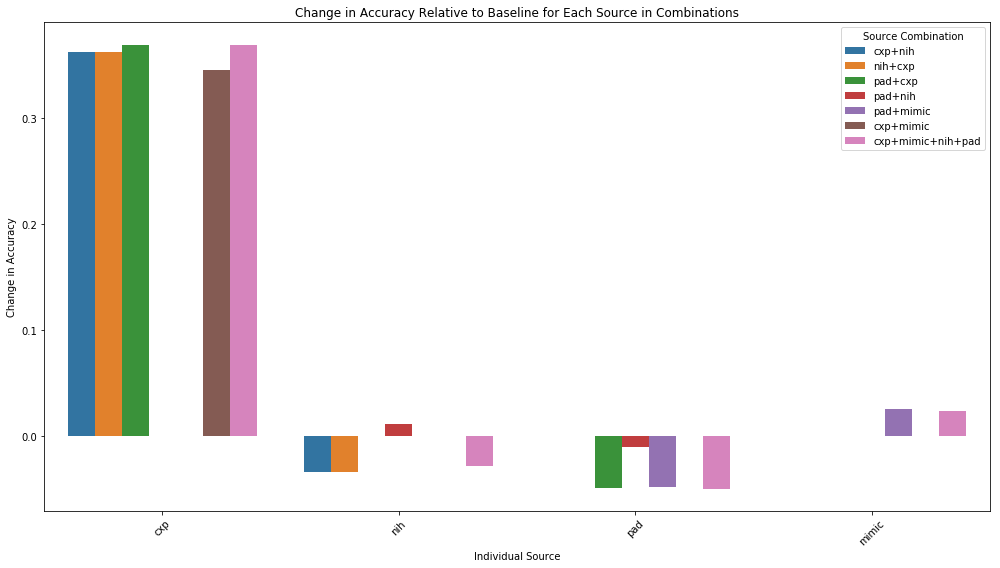

In [148]:
plt.figure(figsize=(14, 8))
sns.barplot(data=accuracy_changes_df, x='part_source', y='change_in_accuracy', hue='source_combination')
plt.title('Change in Accuracy Relative to Baseline for Each Source in Combinations')
plt.ylabel('Change in Accuracy')
plt.xlabel('Individual Source')
plt.xticks(rotation=45)
plt.legend(title='Source Combination', loc='upper right')
plt.tight_layout()
plt.show()

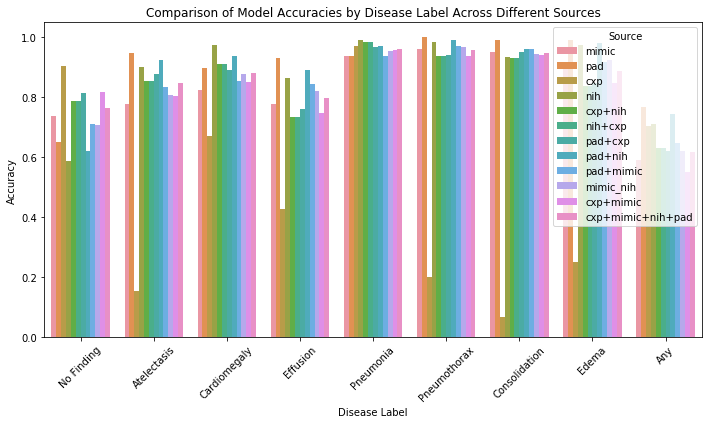

In [149]:
# combined_report['Accuracy'] = combined_report['Accuracy'].str.rstrip('%').astype('float') / 100.0

# Create a bar plot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_report, x='Label', y='Accuracy', hue='source')
plt.title('Comparison of Model Accuracies by Disease Label Across Different Sources')
plt.ylabel('Accuracy')
plt.xlabel('Disease Label')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.tight_layout()
plt.show()


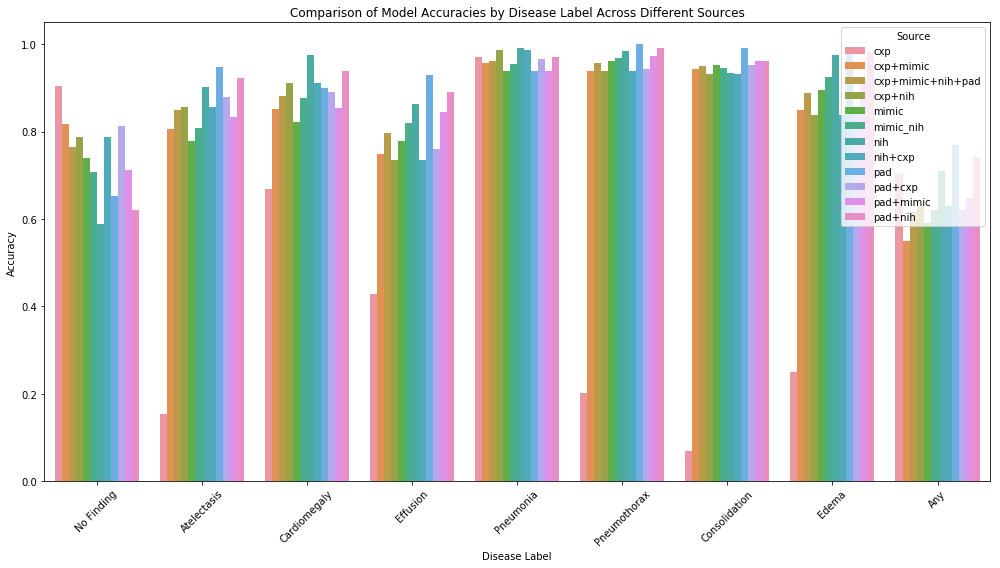

In [150]:
new_report = combined_report
new_report['Group'] = combined_report['source'].apply(lambda x: 'MIMIC' if 'MIMIC' in x else 'Other')

# Sort data first by Group then by source to ensure that combinations with MIMIC are grouped
new_report.sort_values(by=['Group', 'source'], inplace=True)

# Creating the plot
plt.figure(figsize=(14, 8))  # Adjusted for better visibility
sns.barplot(data=new_report, x='Label', y='Accuracy', hue='source')
plt.title('Comparison of Model Accuracies by Disease Label Across Different Sources')
plt.ylabel('Accuracy')
plt.xlabel('Disease Label')
plt.xticks(rotation=45)
plt.legend(title='Source', loc='upper right')  # Adjust legend position if necessary
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

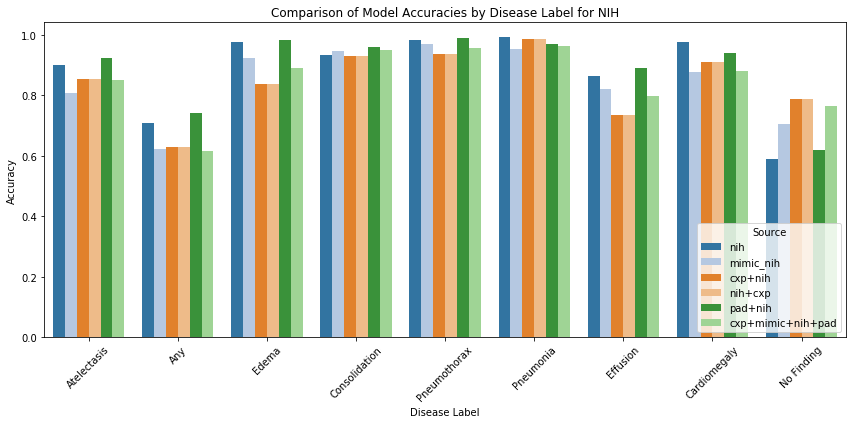

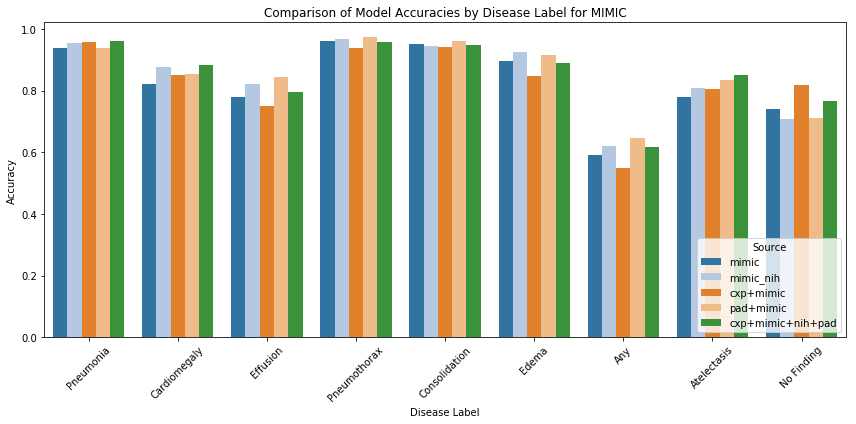

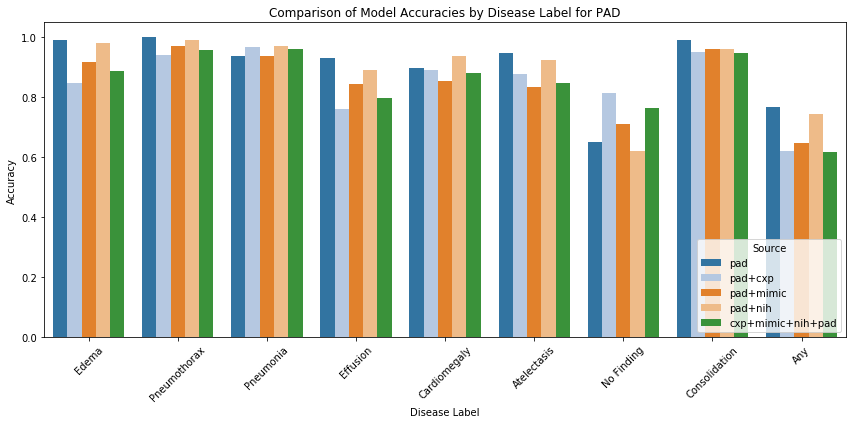

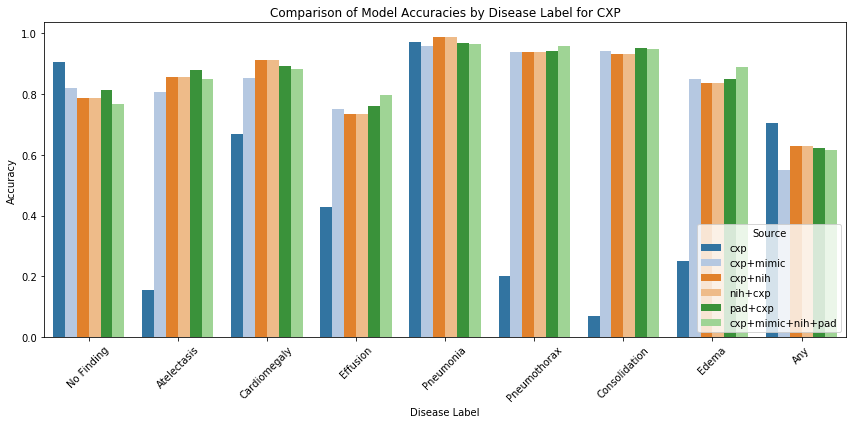

In [165]:
dataset_names = ['nih', 'mimic', 'pad', 'cxp']

for dataset_name in dataset_names:
    # Filter the DataFrame to include only entries where 'source' contains the current dataset
    dataset_specific = combined_report[combined_report['source'].str.contains(dataset_name)]
    
    sorted_sources = sorted(dataset_specific['source'].unique(), key=lambda x: (x.count('+'), x != dataset_name))
    dataset_specific = dataset_specific[dataset_specific['source'].isin(sorted_sources)].sort_values(by='source', key=lambda x: x.map(dict(zip(sorted_sources, range(len(sorted_sources))))))
    
    # Create a figure with adjusted size for clarity
    plt.figure(figsize=(12, 6))
    
    # Create the bar plot
    sns.barplot(data=dataset_specific, x='Label', y='Accuracy', hue='source', palette='tab20')
    
    # Customize the plot with title and labels
    plt.title(f'Comparison of Model Accuracies by Disease Label for {dataset_name.upper()}')
    plt.ylabel('Accuracy')
    plt.xlabel('Disease Label')
    plt.xticks(rotation=45)
    plt.legend(title='Source', loc='lower right')
    
    # Adjust layout to fit everything
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Results

## Model comparison

_You don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper_

Once available, I plan to compare my model performance using different datasets with the results posted in the paper.

# Discussion

## Is the paper reproducible?
It is too early to tell right now, but at least a portion of the code provided is runnable with minimal updates. I was able to reproduce the initial dataset statistics, so at least that portion is definitely reproducible. The rest will depend on whether I am able to solve and run the training.

## If the paper is _not_ reproducible, explain the results
TBD depending on whether the paper results will be reproducible or not.

## What was easy and what was difficult
The authors did a great job documenting some parts of the project, for example, access to data. Following the instructions was very easy, and while MIMIC-CXR-JPG dataset access took some time to get, overall the process was a breeze.

Downloading the datasets is a hassle though, I ran out of space on my laptop, had to buy an external drive and restart the download process for MIMIC-CXR-JPG a few times. In the end, I got a message from my provider that my namely "unlimited" internet for the months was used 100% and I will be charged for each extra GB I use.

There are a few notebooks and standalone scripts provided to process the data. While it is possible to figure out what steps need to be done in what order, many of the parts of the process are not documented. 'pyproject.toml' did not run successfully for me, and I've been stuck trying to figure out why and how to run it (I have a suspicion my processor architecture is not supported, but not enough experience to tell for sure yet).

In parallel, I opted to re-implement the training and model validation myself. There is code for training and validation in the project, which has a lot of comments (great!), but the process itself is not well documented, so the reproducer is left figuring out which steps in the code are needed and which are not, and how to adapt it to use for their experiment. The code is very general and there is a lot of it. There are some pointers in the readme, but they are at this point not sufficient for reproducing things successfully without additional modification.

wandb isn't really working for me either yet, and I am yet to figure out why it is needed and whether it is necessary to reproduce the results. 

The data is not processed evenly / equally for each dataset, there are different values for the same labels (NaN, True/False, 1/0, 1.1/0.0). I had to write some processing code to make sure we mitigate those differences. 

Additional complication is due to the fact that the amount of data is very large. Any training or processing takes a long time, the notebook kernel dies frequently and the overall process is frustrating.

I tried to avoid multiple separate files and scripts, and pulled many of the data preprocessing into my notebook. However, this increased the runtime of the notebook significantly. Additional factor affecting the runtime is the size of the input data, even when working on one dataset. I doubt it would be possible to achieve the 8 minute runtime, but will try to do so.
  
## Suggestions for the author

Trim the codebase leaving only relevant parts. Add documentation for the training and validation process. Add some background on why wandb is used and how to use it for this project correctly. Provide a suggested order of execution for the notebooks.

## Plans for the next phase

In the remaining time until the final submission May 7 deadline, my plans are:
* Further update the data processing functions so they are producing similar type results (right now while compatible, it's a mix of _int_, _float_ and _True/False_, I would like to homogenize the resulting dataset further)
* Finalize the training for the model and compute worst per-group accuracy for all data combinations listed in the article (so far I had the most issues with training, as the code supplied with the article didn't work and I had to come up with my own in which I try to replicate the experiment as close to the article description as possible)
* Plot the results and finalize the writeup (compute both worst per-group accuracy, and AUROC and compare to the results of the article)
* Prepare a subset of data and optimize the notebook to run under 8 minutes if at all possible (as per the original requirements) - this might be complicated as the main focus of this article is dealing with more data and all datasets are quite large. Randomly picking samples from each dataset might further introduce some unintended spurious correlations
* Check the main hypothesis on both balanced and unbalanced datasets, time permitting 
* Prepare a video presentation




# References

1.   Rhys Compton; Lily Zhang; Aahlad Puli; Rajesh Ranganath, When More is Less: Incorporating Additional Datasets Can Hurt Performance By Introducing Spurious Correlations, arXiv preprint, 2023-08-09, Accepted at MLHC 2023, doi: [10.48550/arXiv.2308.04431](https://doi.org/10.48550/arXiv.2308.04431)
2.   Haoran Zhang, Natalie Dullerud, Laleh Seyyed-Kalantari, Quaid Morris, Shalmali Joshi, and Marzyeh Ghassemi. An empirical framework for domain generalization in clinical settings. In Proceedings of the Conference on Health, Inference, and Learning, pages 279–290, 2021, doi: [10.48550/arXiv.2103.11163](https://doi.org/10.48550/arXiv.2103.11163)
3.   Gao Huang, Zhuang Liu, Laurens Van Der Maaten, and Kilian Q Weinberger. Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 4700–4708, 2017, doi: [10.48550/arXiv.1608.06993](https://doi.org/10.48550/arXiv.1608.06993)
4.   Jia Deng, Wei Dong, Richard Socher, Li-Jia Li, Kai Li, and Li Fei-Fei. Imagenet: A large- scale hierarchical image database. In 2009 IEEE Conference on Computer Vision and Pattern Recognition, pages 248–255, 2009, doi: [10.1109/CVPR.2009.5206848](https://doi.org/10.1109/CVPR.2009.5206848)
5.   John R Zech, Marcus A Badgeley, Manway Liu, Anthony B Costa, Joseph J Titano, and Eric Karl Oermann. Variable generalization performance of a deep learning model to detect pneumonia in chest radiographs: a cross-sectional study. PLoS medicine, 15(11): e1002683, 2018, doi: [10.1371/journal.pmed.1002683](https://doi.org/10.1371/journal.pmed.1002683)